In [1]:
options(repr.matrix.max.cols=60, repr.matrix.max.rows=100)

In [2]:
library(tidyverse)
library(ggplot2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [3]:
?extrafont::font_import()

In [4]:
plotdir <- '/home/kpettie/code/github/plotting'
source(file.path(plotdir,"plotting.R"))

In [5]:
fontdir <- '/cashew/shared_data/fonts'
fontname <- 'ArialMT.ttf'
fontpath <- file.path(fontdir,fontname)

In [6]:
fontdir <- '/cashew/shared_data/fonts'
extrafont::font_import(path=fontdir, prompt=FALSE)
extrafont::choose_font('Arial')

Scanning ttf files in /cashew/shared_data/fonts ...

Extracting .afm files from .ttf files...

/cashew/shared_data/fonts/ArialMT.ttf
 : ArialMT already registered in fonts database. Skipping.

Found FontName for 0 fonts.

Scanning afm files in /opt/modules/pkgs/R/4.1.0/lib/R/library/extrafontdb/metrics



[1] "Arial"

In [65]:
outdir <- '/home/kpettie/nf_selection/abc/from_sherlock/abc_1000G/manuscript/figs/noCEU/supp'

# Fig. S2

In [8]:
# a_dir <- '/home/kpettie/nf_selection/abc/from_sherlock/abc_1000G/090422output/diffABC/HiChIP/aggregate'
a_dir <- '/home/kpettie/nf_selection/abc/from_sherlock/abc_1000G/180922outputNoCEU/diffABC/HiChIP/aggregate'
fe <- read_tsv(file.path(a_dir, 
                         'allZerosFilt.meanQN.14.AFR_EUR.diff.allComponents.DEoverlap.fisherEnrichments.txt')) 
fer <- read_tsv(file.path(a_dir, 
                         'allZerosFilt.meanQN.14.AFR_EUR.diff.allComponents.DEoverlap.fisherEnrichmentsDirection.txt')) 

Rows: 1008 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (4): condition, celltype, datatype, score_type
dbl (10): de_significance, enrichment, odds_ratio, pvalue, conf_lower, conf_...
lgl  (2): self_promoter, doublecount_enh

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1008 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): condition, celltype, datatype, score_type
dbl (9): de_significance, odds_ratio, pvalue, conf_lower, conf_upper, DE_up_...
lgl (2): self_promoter, doublecount_enh

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
fef <- fe %>% 
    dplyr::filter(datatype %in% c('bulk','pseudobulk'),
                  score_type %in% c('atac.Score','chip.Score')) %>% 
    group_by(score_type) %>% 
    arrange(celltype, condition, .by_group=TRUE) %>% 
    ungroup()

In [10]:
fe <- fe %>% 
    mutate(score_type = case_when(score_type=='ABC.Score' ~ 'ABC',
                                  score_type=='atac.Score' ~ 'ATAC',
                                  score_type=='chip.Score' ~ 'ChIP',
                                  score_type=='hic.Score' ~ 'HiC'),
           celltype_condition = paste(celltype, condition))

In [11]:
fer <- fer %>% 
    mutate(score_type = case_when(score_type=='ABC.Score' ~ 'ABC',
                                  score_type=='atac.Score' ~ 'ATAC',
                                  score_type=='chip.Score' ~ 'ChIP',
                                  score_type=='hic.Score' ~ 'HiC'),
           celltype_condition = paste(celltype, condition))

In [12]:
cre_colors <- c("#DF241B", "#739893")
fe <- fe %>% 
    mutate(self_promoter=if_else(self_promoter, 'promoter','enhancer'))

In [13]:
fer <- fer %>% 
    mutate(self_promoter=if_else(self_promoter, 'promoter','enhancer'))

In [14]:
afe <- rbind(
    fe %>% 
        select(-enrichment,-de_significance,-starts_with(c('fg_','bg_'))) %>% 
        mutate(test_type = 'diff'),
    fer %>% 
        select(-starts_with('DE_')) %>% 
        mutate(test_type = 'direction')
)

## b

In [48]:
plotFisherEnrichments <- function(df,
                                  yvar_col='condition',
                                  ylabel=yvar_col,
                                  xvar_col='odds_ratio',
                                  xlabel=xvar_col,
                                  althypoth='greater',
                                  success_total=FALSE, # display total success number instead of total elements in test
                                  line_intercept=1,
                                  groupvar=NULL,
                                  groupvarlab=groupvar,
                                  groupvarord=NULL,
                                  colorvals=NULL,
                                  sep_groups=TRUE,
                                  dodgewidth=0.4,
                                  w=7,
                                  h=7,
                                  facets=NULL,
                                  frows=2,
                                  fscales='fixed', # free, free_x, free_y
                                  fdir='h',
                                  ngenessize=6,
                                  ngenes_lim_adj=6.4,
                                  ngenes_or_adj=.3,
                                  legendpos=NULL, # c(xpos, ypos)
                                  legtextsize=22,
                                  debug=FALSE
                                 ) {

    if ('fg_total' %in% colnames(df)) {
        df <- df %>% mutate(nGenes = fg_total + bg_total)
    }
    if ('DE_up_DA_up' %in% colnames(df)) {
        df <- df %>% dplyr::rename(up_up = DE_up_DA_up,
                                   up_down = DE_up_DA_down,
                                   down_up = DE_down_DA_up,
                                   down_down = DE_down_DA_down)
    }
    if ('up_up' %in% colnames(df)) {
        if (success_total) {
            df <- df %>% mutate(nGenes = up_up + down_up)
        } else {
            df <- df %>% mutate(nGenes = up_up + up_down + down_up + down_down)
        }

    }
    if ('n_trials' %in% colnames(df)) {
        if (any(!is.na(df['n_trials']))) {
            df <- df %>% mutate(nGenes = n_trials)
        }
    }

    # get bonferroni P to display asterisk significance
    df <- df %>%
        mutate(nGenes = as.character(nGenes),
               nGenes = case_when(padj < 0.00005 ~ paste0(nGenes, '****'),
                                  padj < 0.0005 ~ paste0(nGenes, '***'),
                                  padj < 0.005 ~ paste0(nGenes, '**'),
                                  padj < 0.05 ~ paste0(nGenes, '*'),
                                  TRUE ~ nGenes))

    df <- df %>% dplyr::rename(yvar := {{yvar_col}},
                               odds_ratio := {{xvar_col}})
    if (!is.null(groupvar)) {
        df <- df %>%
            dplyr::rename(gvc := {{groupvar}})
        if (is.null(facets)) {
            if (!is.null(groupvarord)) {
                df <- df %>%
                    mutate(gvc = as.factor(gvc),
                           gvc = fct_reorder(gvc, groupvarord))
            } else {
                df <- df %>%
                    mutate(gvc = as.factor(gvc),
                           gvc = fct_relevel(gvc, rev))
            }
        }

        posd <- position_dodge(dodgewidth)
        ewidth <- 0.2
    } else {
        if ('hex' %in% colnames(df)) {
            df <- df %>%
                dplyr::mutate(gvc = hex)
        } else {
            gvc <- NULL
        }
        posd <- 'identity'
        ewidth <- 0.1
    }
    if (althypoth=='greater') {
        df <- df %>% mutate(ymaxcol = odds_ratio)
    } else {
        df <- df %>% mutate(ymaxcol = conf_upper)
    }

    options(repr.plot.width = w, repr.plot.height = h, repr.plot.res = 200)

    df <- df %>%
        group_by(across(all_of(facets))) %>%
        mutate(yvar = as.factor(yvar),
               yvar = fct_reorder(yvar, conf_lower),
               or_inf = max(ymaxcol[is.finite(ymaxcol)]))
    
    # if x-axis fixed across facets, perform same adjustment to accommodate ngenes labels in each
    if (fscales != 'free_x') df <- df %>% ungroup()
    if (max(df[is.finite(df$ymaxcol),]$ymaxcol) - min(df[is.finite(df$ymaxcol),]$ymaxcol) > 100) {
        logscale <- TRUE
        df <- df %>%
            mutate(or_offset = if_else(is.finite(ymaxcol), ngenes_or_adj*ymaxcol, ngenes_or_adj*or_inf))
    } else {
        logscale <- FALSE
        df <- df %>%
            mutate(or_offset = max((.15*ngenes_or_adj)*(max(ymaxcol[is.finite(ymaxcol)]) - min(ymaxcol)), (.15*ngenes_or_adj)))
    }

    # amount of space to add within plotting range for points/significance labels to be visible
    ylimadj <- 2
    if ('nGenes' %in% colnames(df)) {
        if (max(nchar(df$nGenes)) > 2) ylimadj <- ngenes_lim_adj 
    }
    df <- df %>%
        mutate(or_ylim = max(ymaxcol[is.finite(ymaxcol)]) + max(or_offset)*ylimadj)
    
    if (debug) return(df)

    if (!is.null(facets) & sep_groups) {
        labexp <- 0.5
        df <- df %>%
            ungroup() %>%
            dplyr::rename(yvar_names = yvar) %>%
            group_by(across(all_of(facets))) %>%
            arrange(conf_lower, .by_group=TRUE) %>%
            ungroup() %>%
            mutate(yvar = row_number()) %>%
            group_by(across(all_of(facets))) %>%
            mutate(labs_xlim_lower = min(yvar) - labexp,
                   labs_xlim_upper = max(yvar) + labexp) %>%
            ungroup()
    }

    # dummy df for plottin blank space for text labels
    ylim_blank <- df %>%
        group_by(across(all_of(facets))) %>%
        dplyr::select(yvar,any_of(c(facets,'odds_ratio','or_ylim')))

    p1 <- ggplot(df, aes(x=yvar, y=odds_ratio, color=gvc)) +
        geom_errorbar(aes(ymin=conf_lower, ymax=ymaxcol), width=ewidth, position=posd) +
        geom_point(position=posd, size=4)

    if ('nGenes' %in% colnames(df)) {

        p1 <- p1 + geom_text(position=posd,size=ngenessize,aes(y=ymaxcol+or_offset,label=nGenes,hjust=0), show.legend=FALSE )

    }

    p1 <- p1 +
        geom_blank(data=ylim_blank, aes(x=yvar, y=or_ylim, color=NULL)) +
        geom_hline(yintercept=line_intercept, linetype='dashed', color='gray') +
        coord_flip() +
        theme_classic() +
        labs(x=ylabel,
             y=xlabel)

    if ('nGenes' %in% colnames(df)) {

        if (!all(is.finite(df$odds_ratio))) {
            p1 <- p1 +
                geom_text(data=df[!is.finite(df$odds_ratio),],
                          position=posd,size=ngenessize,
                          aes(y=or_inf+or_offset,label=nGenes,hjust=0,vjust=-0.5), show.legend=FALSE)
        }

    }



    if (logscale) {
        p1 <- p1 + scale_y_log10() + theme(plot.margin = unit(c(0,2,0,0),"line"))
    } else {
        p1 <- p1 + theme(plot.margin = unit(c(0,1.5,0,0),"line"))
    }

    if ('hex' %in% colnames(df)) {
        p1 <- p1 +
            scale_color_identity(breaks=df$hex, labels=df$category, guide='legend')
    } else {
        if (!is.null(colorvals)) p1 <- p1 + scale_color_manual(values=colorvals)
        if (!is.null(groupvar)) p1 <- p1 + labs(color=groupvarlab) + guides(color=guide_legend(reverse=TRUE))
    }

    if (!is.null(facets)) {
        p1 <- p1 +
            facet_wrap(facets, nrow=frows, dir=fdir, scales=fscales)
        if (sep_groups) {
            p1 <- p1 +
                geom_blank(data=df, aes(x=labs_xlim_lower, y=or_ylim, color=NULL)) +
                geom_blank(data=df, aes(x=labs_xlim_upper, y=or_ylim, color=NULL)) +
                scale_x_continuous(breaks=df$yvar, labels=df$yvar_names, expand=c(0,0))
        }

    }

    if (is.null(legendpos)) {
        if (!is.null(facets)) {
            legendpos <- c(.4,.2)
        } else {
            legendpos <- c(.8,.2)
        }
    }

    if (is.null(groupvarlab)) {
        p1 <- p1 +
            theme(legend.title = element_blank(),
                  legend.text = element_text(size=legtextsize))
    } else {
        p1 <- p1 +
            labs(color=groupvarlab) +
            theme(legend.title = element_text(size=legtextsize+2),
                  legend.text = element_text(size=legtextsize))
    }

    p1 <- p1 +
        theme(axis.text.x = element_text(size=22),
              axis.text.y = element_text(size=22),
              axis.title.x = element_text(size=28),
              axis.title.y = element_text(size=28),
              legend.position=legendpos,
              strip.background = element_blank(),
              strip.placement = "outside",
              strip.text = element_text(size=22),
              panel.spacing = unit(2, "line"))

    return(p1)

}

envCellTypeGridPlot <- function(df,
                                p1color_table,
                                p1filt='bulk',
                                p2filt='pseudobulk',
                                gtitle="Diff-score - DE gene enrichments",
                                dim1=c(10,10),
                                dim2=c(10,10),
                                ngenes_lim_adj=6.4,
                                debug=FALSE) {

    p1 <- plotFisherEnrichments(df %>%
                                    dplyr::filter(datatype==p1filt) %>%
                                    merge(., p1color_table),
                            yvar_col = "condition",
                            ylabel = "Condition",
                                xlabel = "Odds ratio",
                            althypoth = "greater",
                            groupvar = NULL,
                            legendpos = 'top',
                            groupvarord = NULL,
                            colorvals = NULL,
                            w = dim1[1], h = dim1[2],
                            facets = 'score_type',
                            frows = 2,
                            fscales = "free_y",
                               ngenes_lim_adj=ngenes_lim_adj,
                            debug=debug)

    p2 <- plotFisherEnrichments(df %>%
                                dplyr::filter(datatype==p2filt),
                            yvar_col = "celltype",
                            ylabel = "Cell type", 
                                xlabel = "Odds ratio",
                                althypoth = "greater",
                            groupvar = "condition",
                            groupvarlab = NULL,
                            colorvals = c('darkred','darkgray'),
                            legendpos = 'top', w = dim2[1], h = dim2[2],
                            facets = "score_type", frows = 2,
                            fscales = "free_y",
                            ngenes_lim_adj=ngenes_lim_adj,
                            debug=debug)
    
    if (debug) return(p1)

    # if(!(require(gridExtra) )) install.packages("gridExtra")

    options(repr.plot.width = dim1[1] + dim2[1], repr.plot.height = dim1[2] + dim2[2], repr.plot.res = 200)

    g1 <- gridExtra::grid.arrange(
      p1 + theme(plot.margin = unit(c(0,3,0,0),"line")),
      p2 + theme(plot.margin = unit(c(0,1.5,0,0),"line")),
      nrow = 1,
      top = grid::textGrob(
           gtitle,
           gp = grid::gpar(fontsize = 26)
      ),
      padding = unit(3, "line")
    )

    return(g1)

}

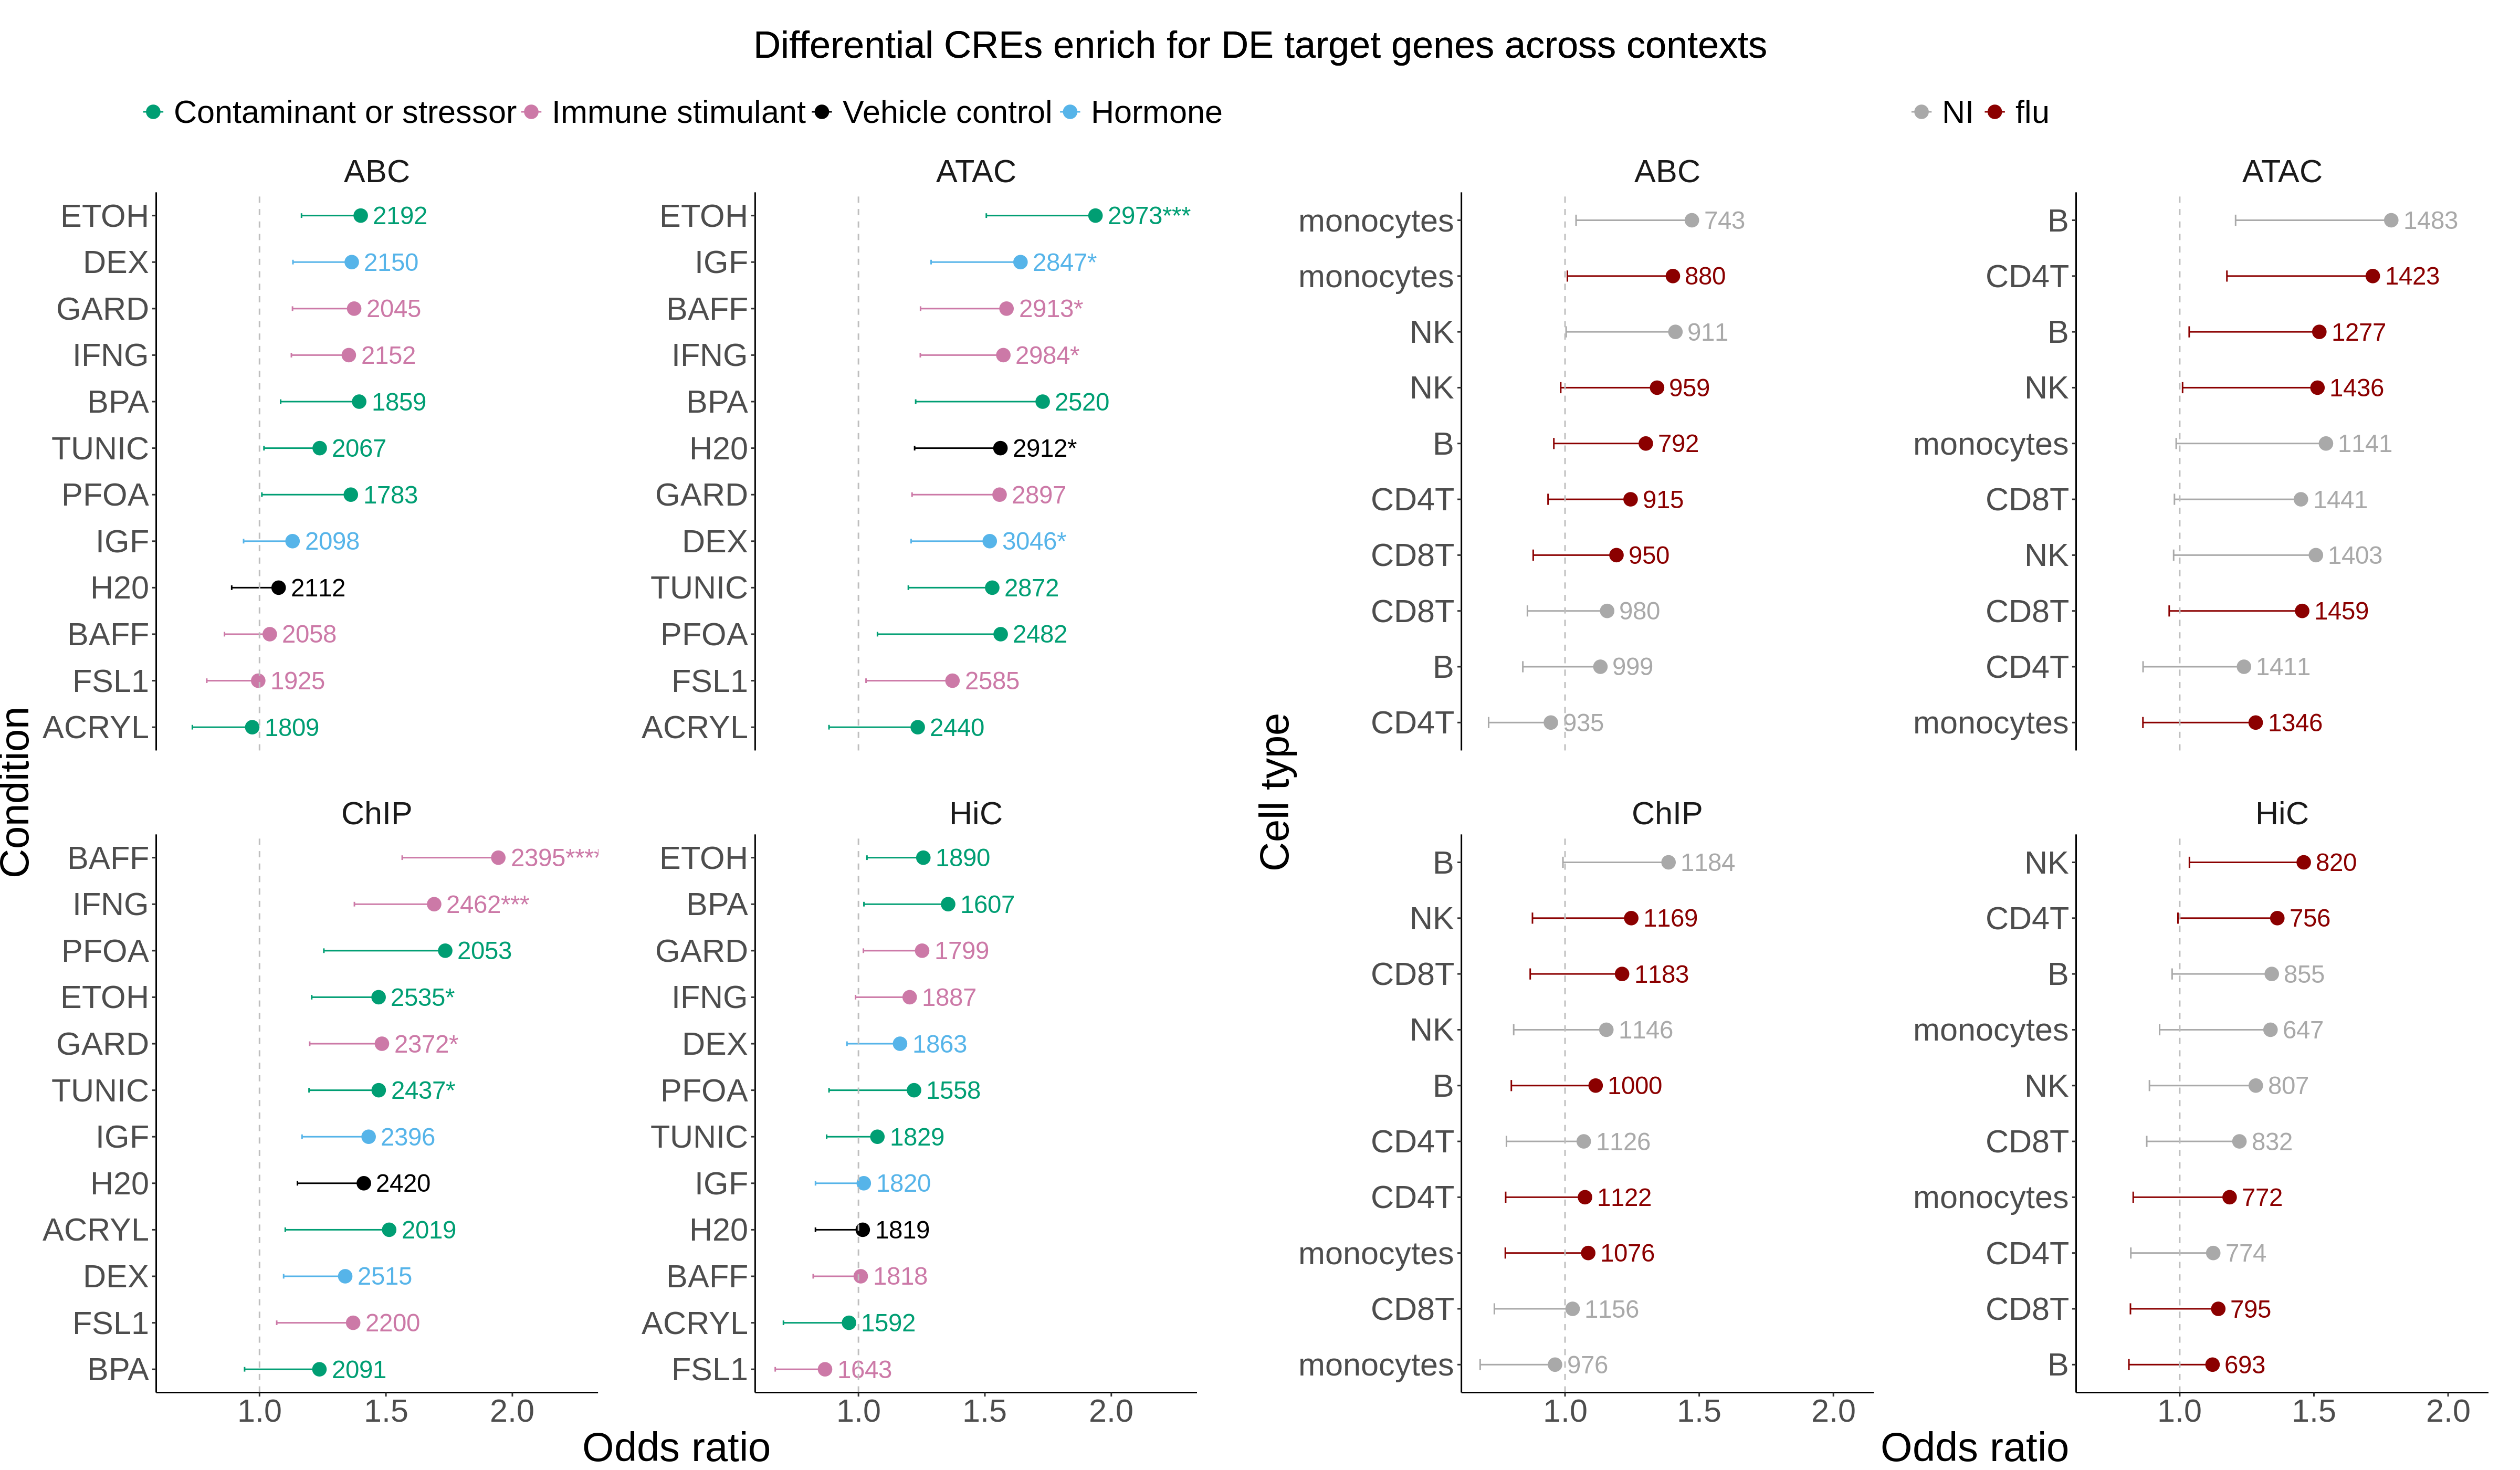

In [49]:
dim1 <- c(12,7)
dim2 <- c(12,7)
combdims <- c(dim1[1] + dim2[1], dim1[2] + dim2[2])

sdim <- c(10.5,18)

envPlotColors <- tribble(
                    ~condition,  ~hex, ~category,
                    'GARD',  "#CC79A7", 'Immune stimulant',
                    'FSL1',  "#CC79A7", 'Immune stimulant',
                    'IFNG',  "#CC79A7", 'Immune stimulant',
                    'BAFF',  "#CC79A7", 'Immune stimulant',
                    'DEX',   "#56B4E9", 'Hormone',
                    'IGF',   "#56B4E9", 'Hormone',
                    'ACRYL', "#009E73", 'Contaminant or stressor',
                    'PFOA',  "#009E73", 'Contaminant or stressor',
                    'BPA',   "#009E73", 'Contaminant or stressor',
                    'TUNIC', "#009E73", 'Contaminant or stressor',
                    'ETOH',  "#009E73", 'Contaminant or stressor',
                    'H20',   "#000000", 'Vehicle control'
                )

ntests <- 44

g2 <- envCellTypeGridPlot(fe %>%
                              dplyr::filter(is.na(self_promoter),
                                            !doublecount_enh) %>% 
                              mutate(padj = case_when(score_type %in% c('ATAC','ChIP') ~ pvalue*ntests,
                                                      TRUE ~ 1)),
                    envPlotColors,
                    p1filt='bulk',
                    p2filt='pseudobulk',
                    gtitle="Differential CREs enrich for DE target genes across contexts",
                    dim1=dim1,
                    dim2=dim2,
                    ngenes_lim_adj=6.5)
grid::grid.draw(g2)


ggsave(
    file.path(
        outdir, 
        'Fig2a.png'
    ), 
    plot=g2, 
    width=combdims[1], 
    height=combdims[2]
)

## d

In [59]:
fer %>%
                              dplyr::filter(is.na(self_promoter),
                                            !doublecount_enh,
                                            celltype!='LCL',
                                            score_type %in% c('ATAC','ChIP'),
                                            pvalue < 0.05) %>% 
    arrange(score_type, pvalue)

de_significance,odds_ratio,pvalue,conf_lower,conf_upper,DE_up_DA_up,DE_up_DA_down,DE_down_DA_up,DE_down_DA_down,condition,celltype,datatype,self_promoter,doublecount_enh,score_type,celltype_condition
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>
0.05,1.746093,0.019763046,1.110762,Inf,60,60,48,84,NI,CD8T,pseudobulk,NA,FALSE,ATAC,CD8T NI
0.05,1.794862,0.020627524,1.111792,Inf,58,47,48,70,flu,monocytes,pseudobulk,NA,FALSE,ATAC,monocytes flu
0.05,1.820635,0.024282444,1.096791,Inf,48,46,40,70,NI,monocytes,pseudobulk,NA,FALSE,ATAC,monocytes NI
0.05,2.463606,0.030457625,1.102610,Inf,16,10,51,79,NI,NK,nzfraction,NA,FALSE,ATAC,NK NI
0.05,1.644784,0.037137977,1.036878,Inf,63,64,43,72,flu,NK,pseudobulk,NA,FALSE,ATAC,NK flu
0.05,2.020831,0.006178365,1.254983,Inf,61,37,61,75,flu,CD4T,pseudobulk,NA,FALSE,ChIP,CD4T flu
0.05,2.118161,0.010245106,1.224791,Inf,52,31,41,52,NI,B,pseudobulk,NA,FALSE,ChIP,B NI
0.05,8.931307,0.019602065,1.358714,Inf,7,1,40,52,flu,CD8T,nzfraction,NA,FALSE,ChIP,CD8T flu
0.05,2.056472,0.024936993,1.111947,Inf,43,32,26,40,NI,NK,pseudobulk,NA,FALSE,ChIP,NK NI


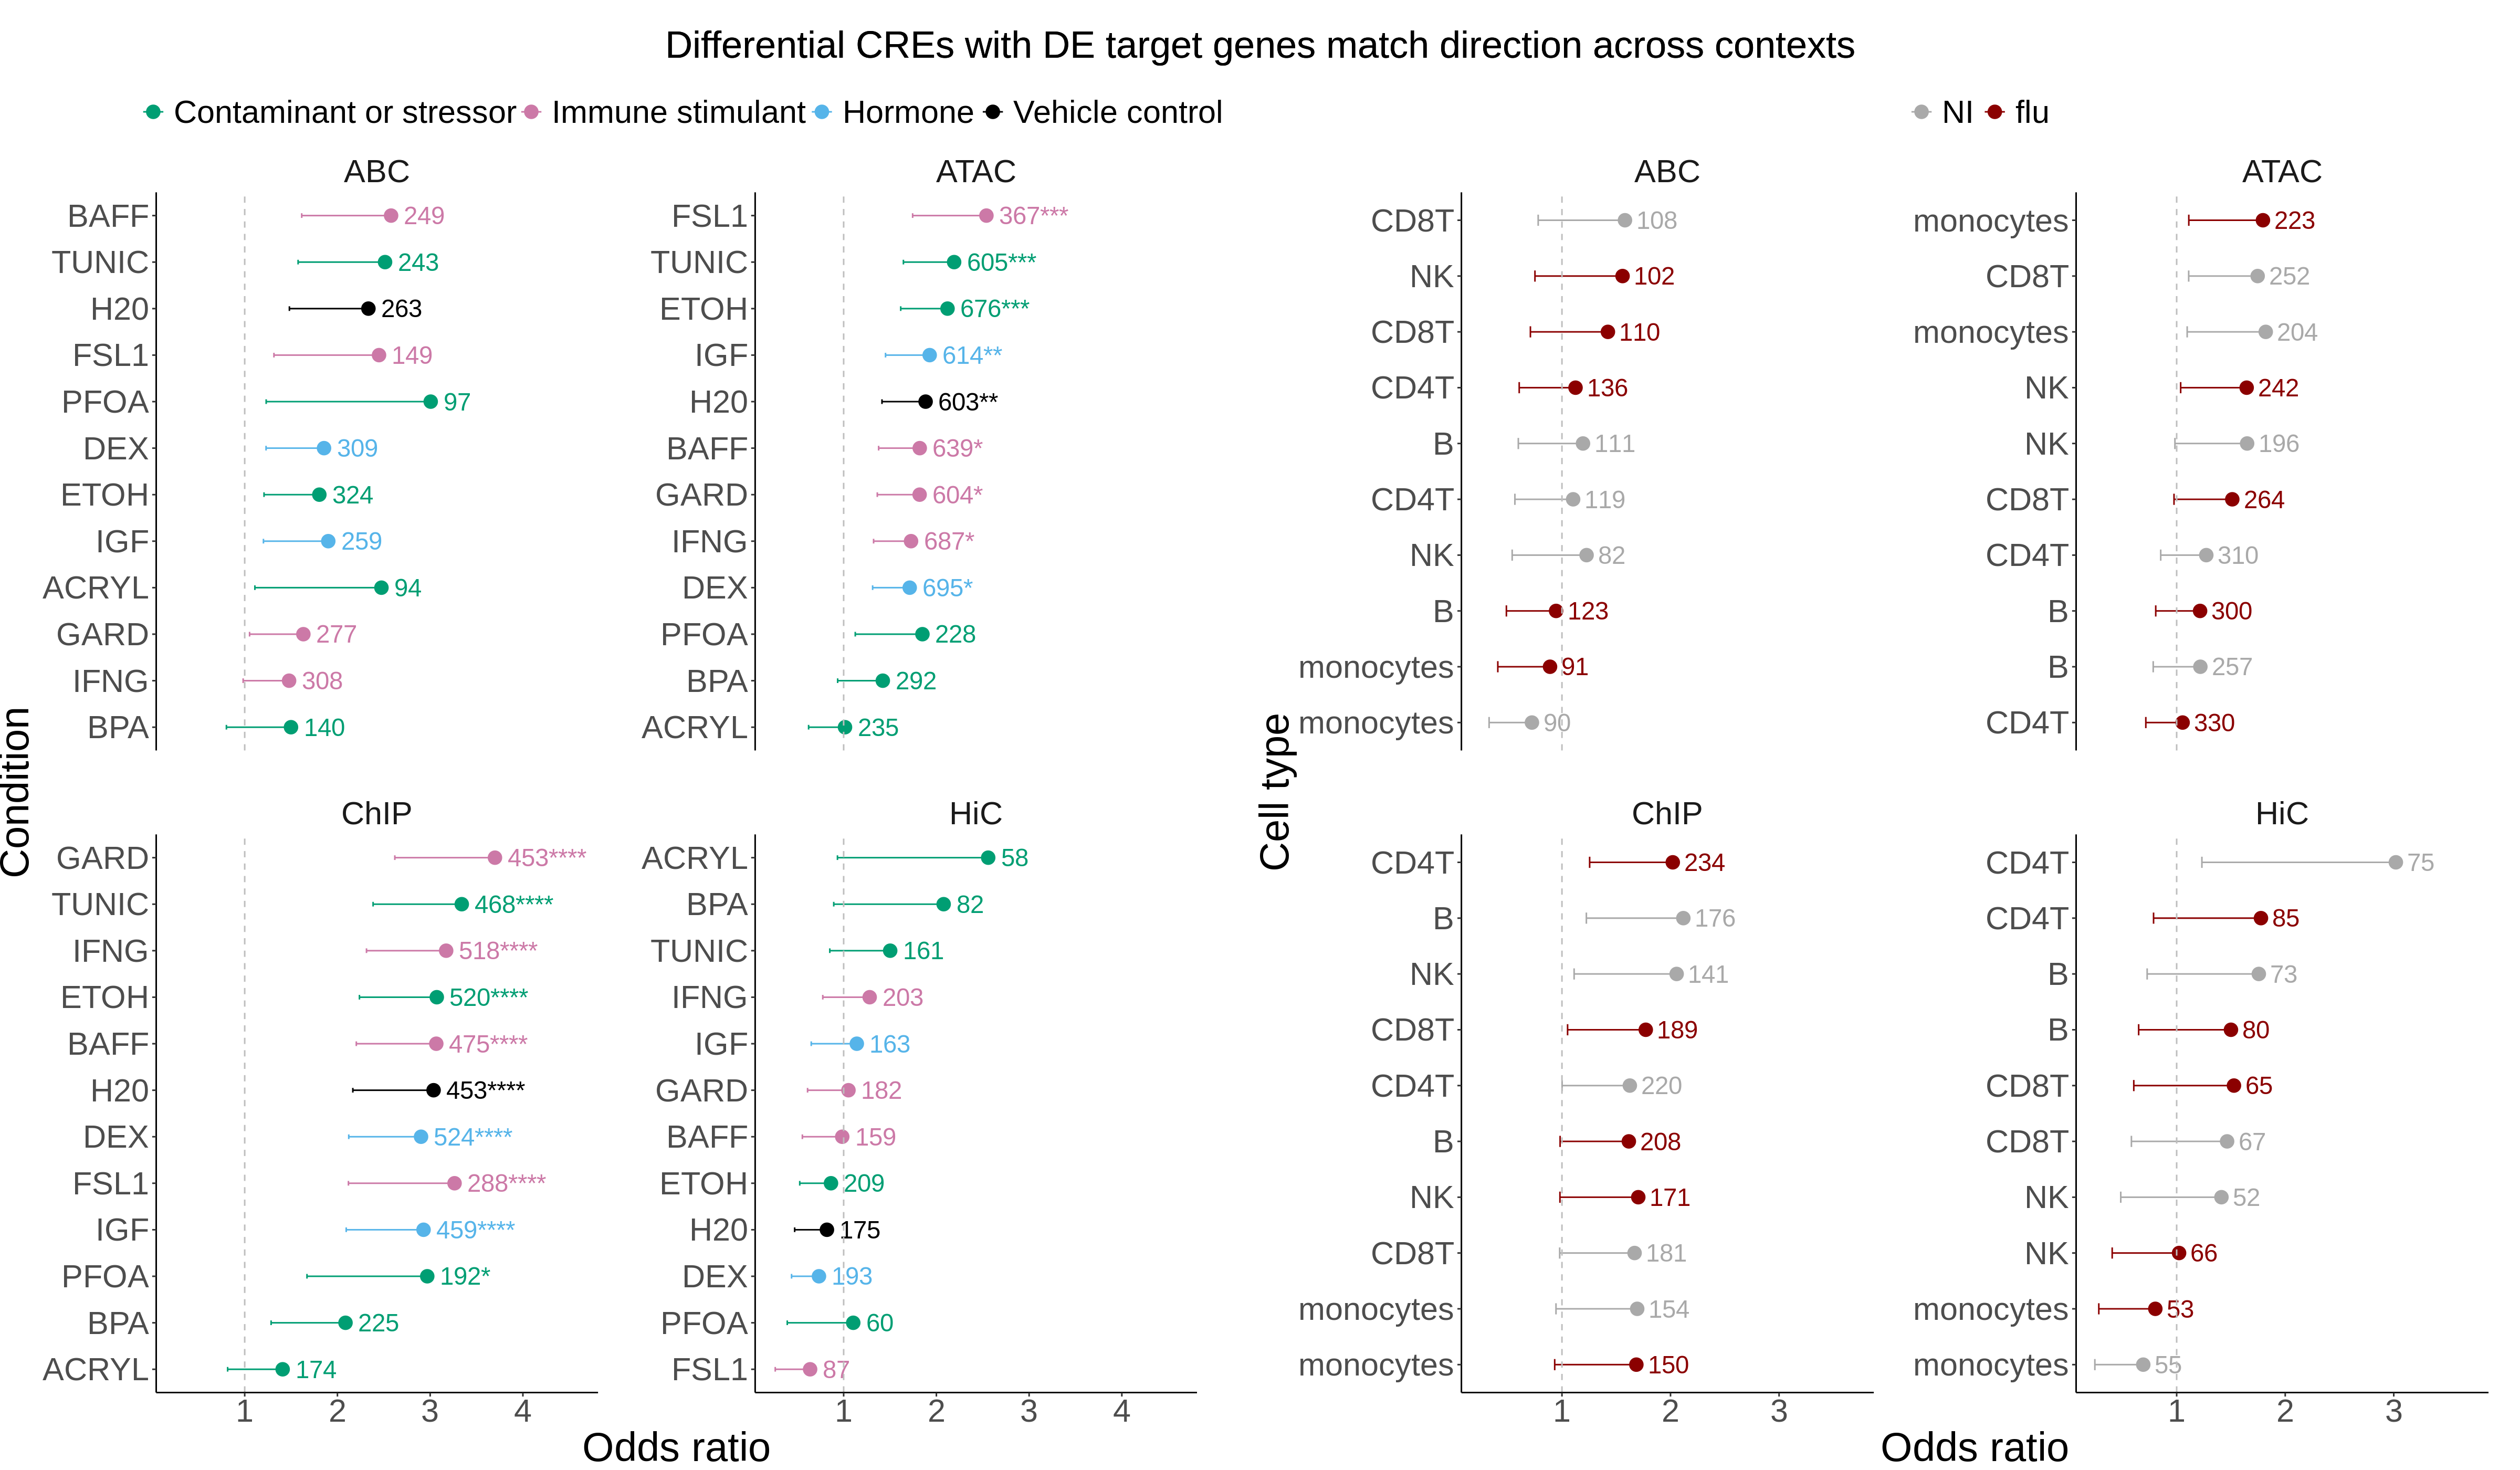

In [50]:
g3 <- envCellTypeGridPlot(fer %>%
                              dplyr::filter(is.na(self_promoter),
                                            !doublecount_enh) %>% 
                              mutate(padj = case_when(score_type %in% c('ATAC','ChIP') ~ pvalue*ntests,
                                                      TRUE ~ 1)),
                    envPlotColors,
                    p1filt='bulk',
                    p2filt='pseudobulk',
                    gtitle="Differential CREs with DE target genes match direction across contexts",
                    dim1=dim1,
                    dim2=dim2,
                    ngenes_lim_adj=6.5,
                    debug=FALSE)

# g3
grid::grid.draw(g3)

ggsave(
    file.path(
        outdir, 
        'Fig2b.png'
    ), 
    plot=g3, 
    width=combdims[1], 
    height=combdims[2]
)

# Fig. S2

## e

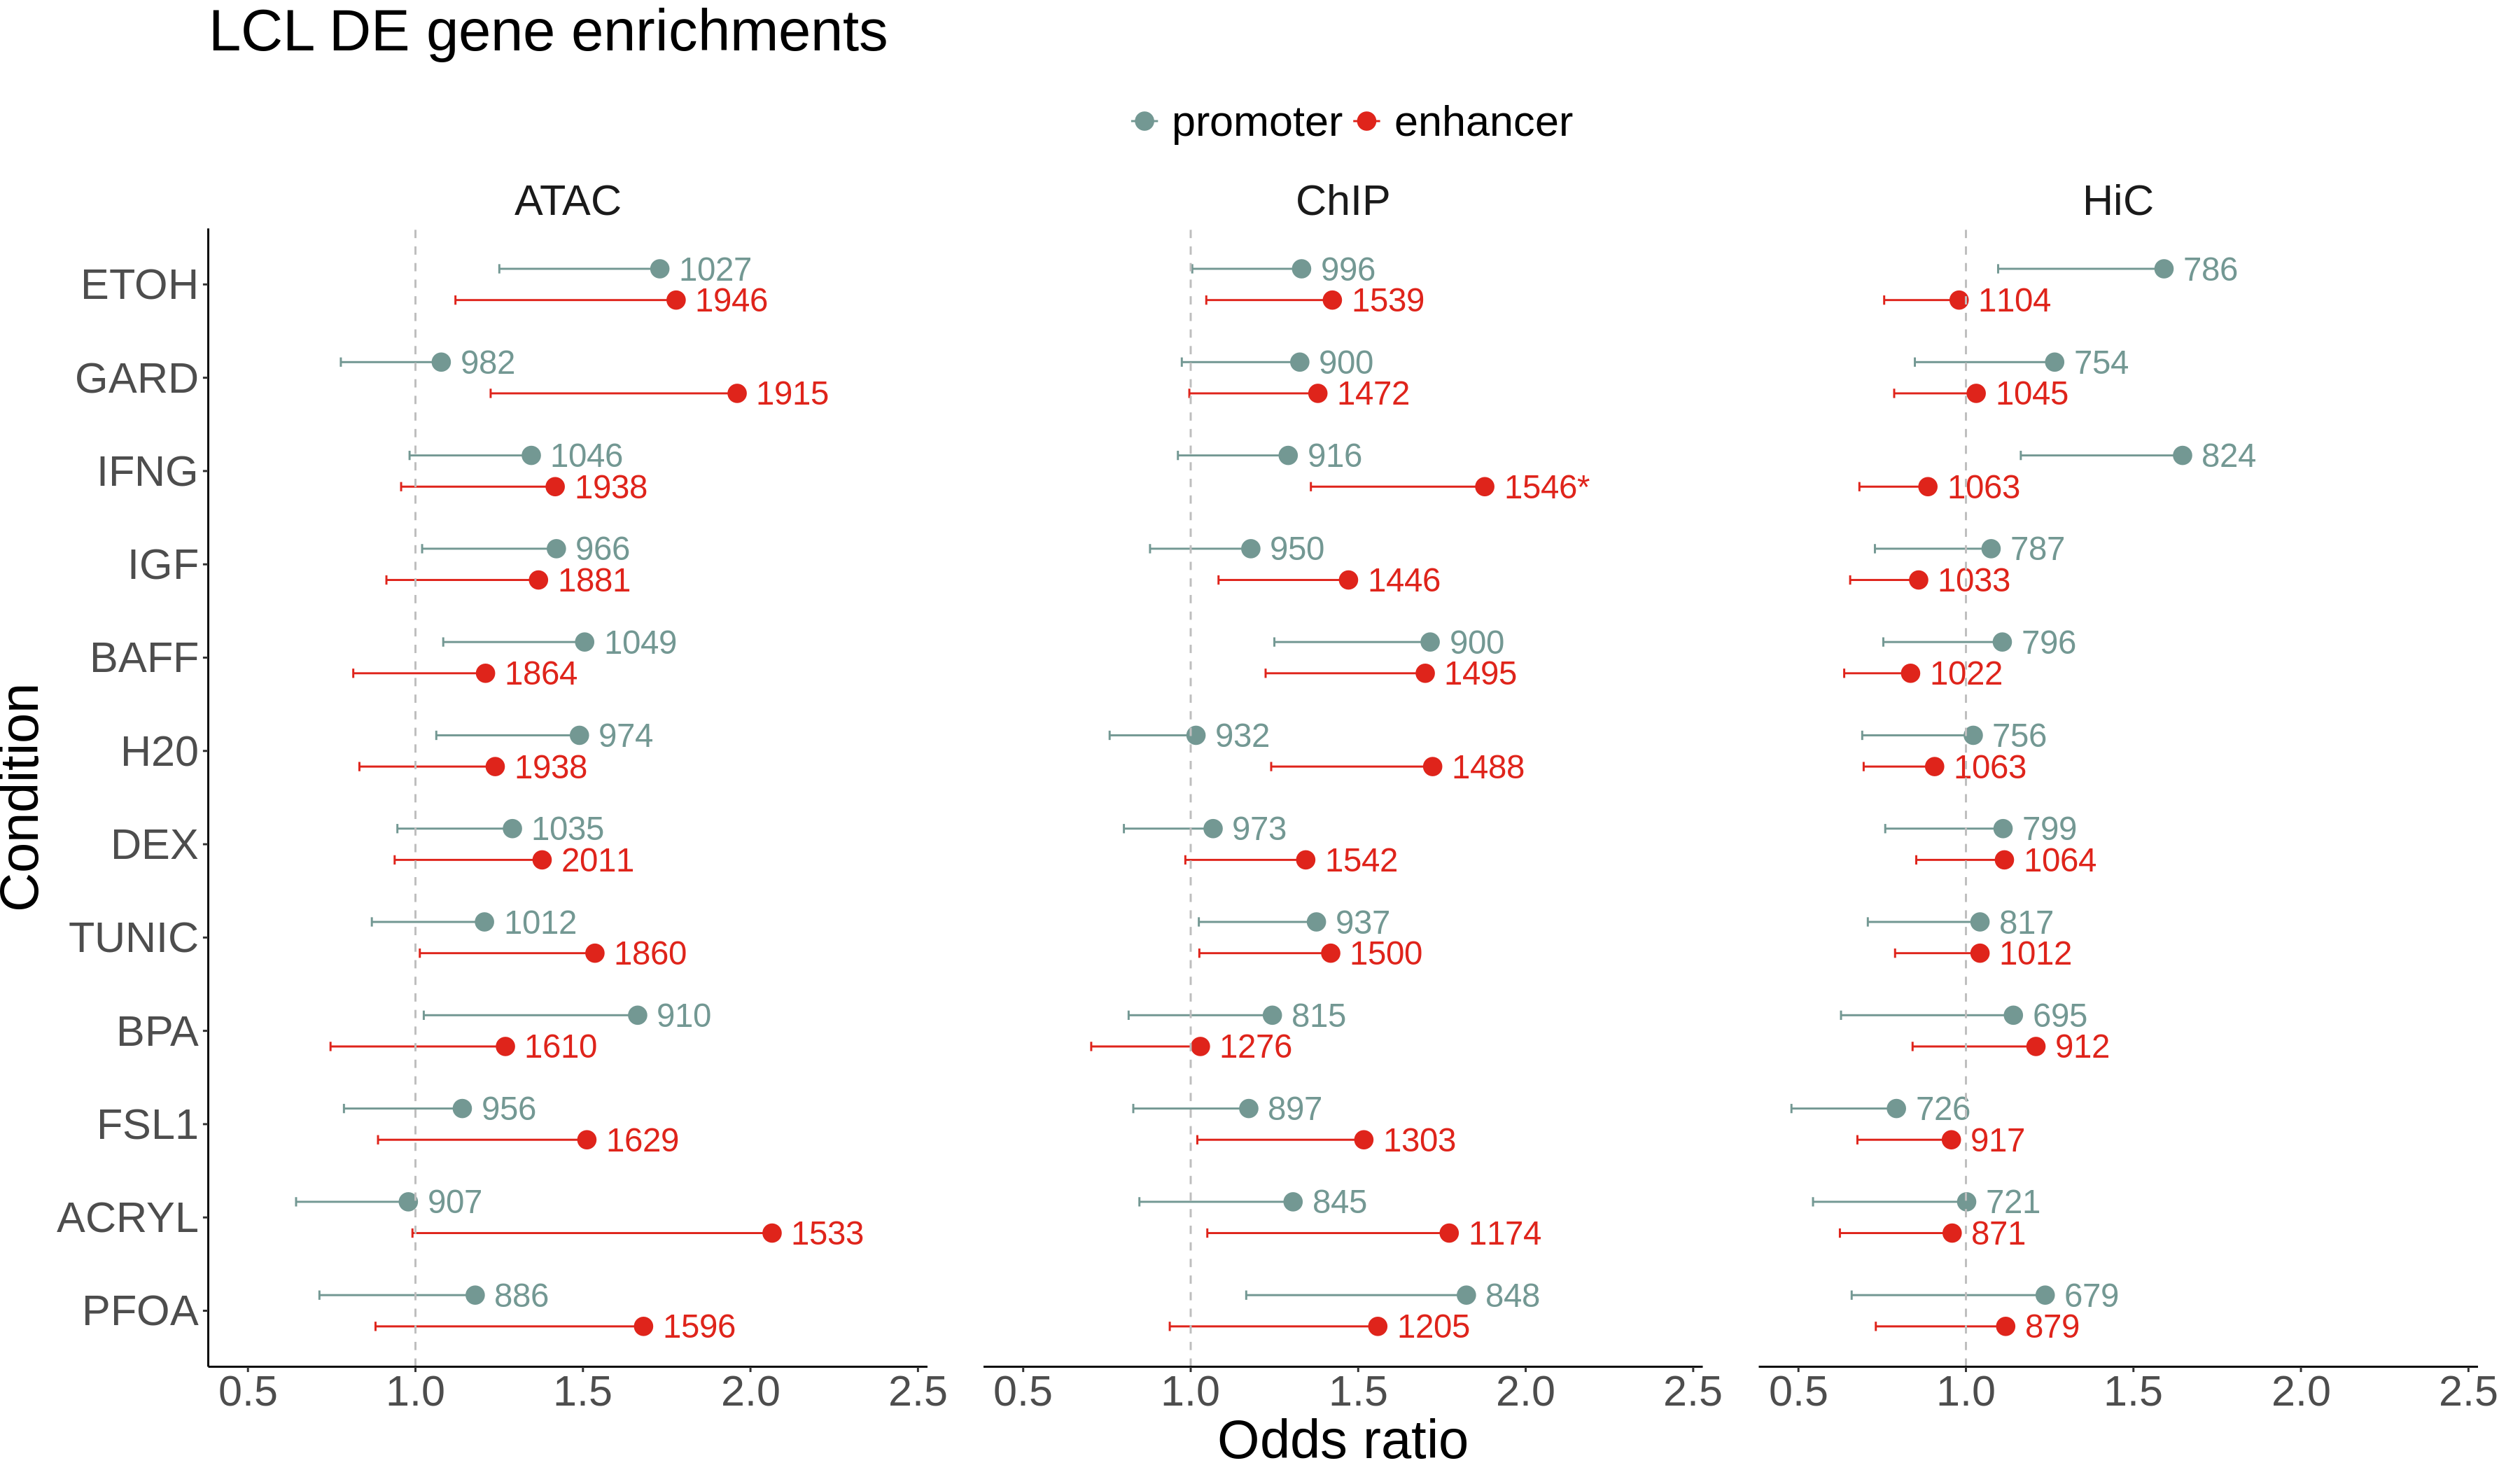

In [51]:
ntests <- 88

plotFisherEnrichments(fe %>% 
                          dplyr::filter(datatype=='bulk',
                                        !is.na(self_promoter),
                                            !doublecount_enh,
                                        score_type!='ABC') %>% 
                              mutate(padj = case_when(score_type %in% c('ATAC','ChIP') ~ pvalue*ntests,
                                                      TRUE ~ 1)),
                      yvar_col='condition',
                      ylabel='Condition',
                      xlabel="Odds ratio",
                      althypoth='greater',
                      groupvar='self_promoter',
                      groupvarlab=NULL,
                      colorvals=cre_colors,
                      groupvarord=NULL,
                      sep_groups=FALSE,
                      dodgewidth=0.67,
                      w=sdim[2],
                      h=sdim[1],
                      facets='score_type',
                      frows=1,
                      fscales='fixed', # free, free_x, free_y
                      fdir='h',
                      legendpos='top', # c(xpos, ypos)
                      debug=FALSE) + 
        ggtitle("LCL DE gene enrichments") +
        theme(plot.title = element_text(size=30, hjust=0, margin=margin(5,0,15,0)))

ggsave(
    file.path(
        outdir, 
        'FigS2a.png'
    ),
    width=sdim[2], 
    height=sdim[1]
)

## f

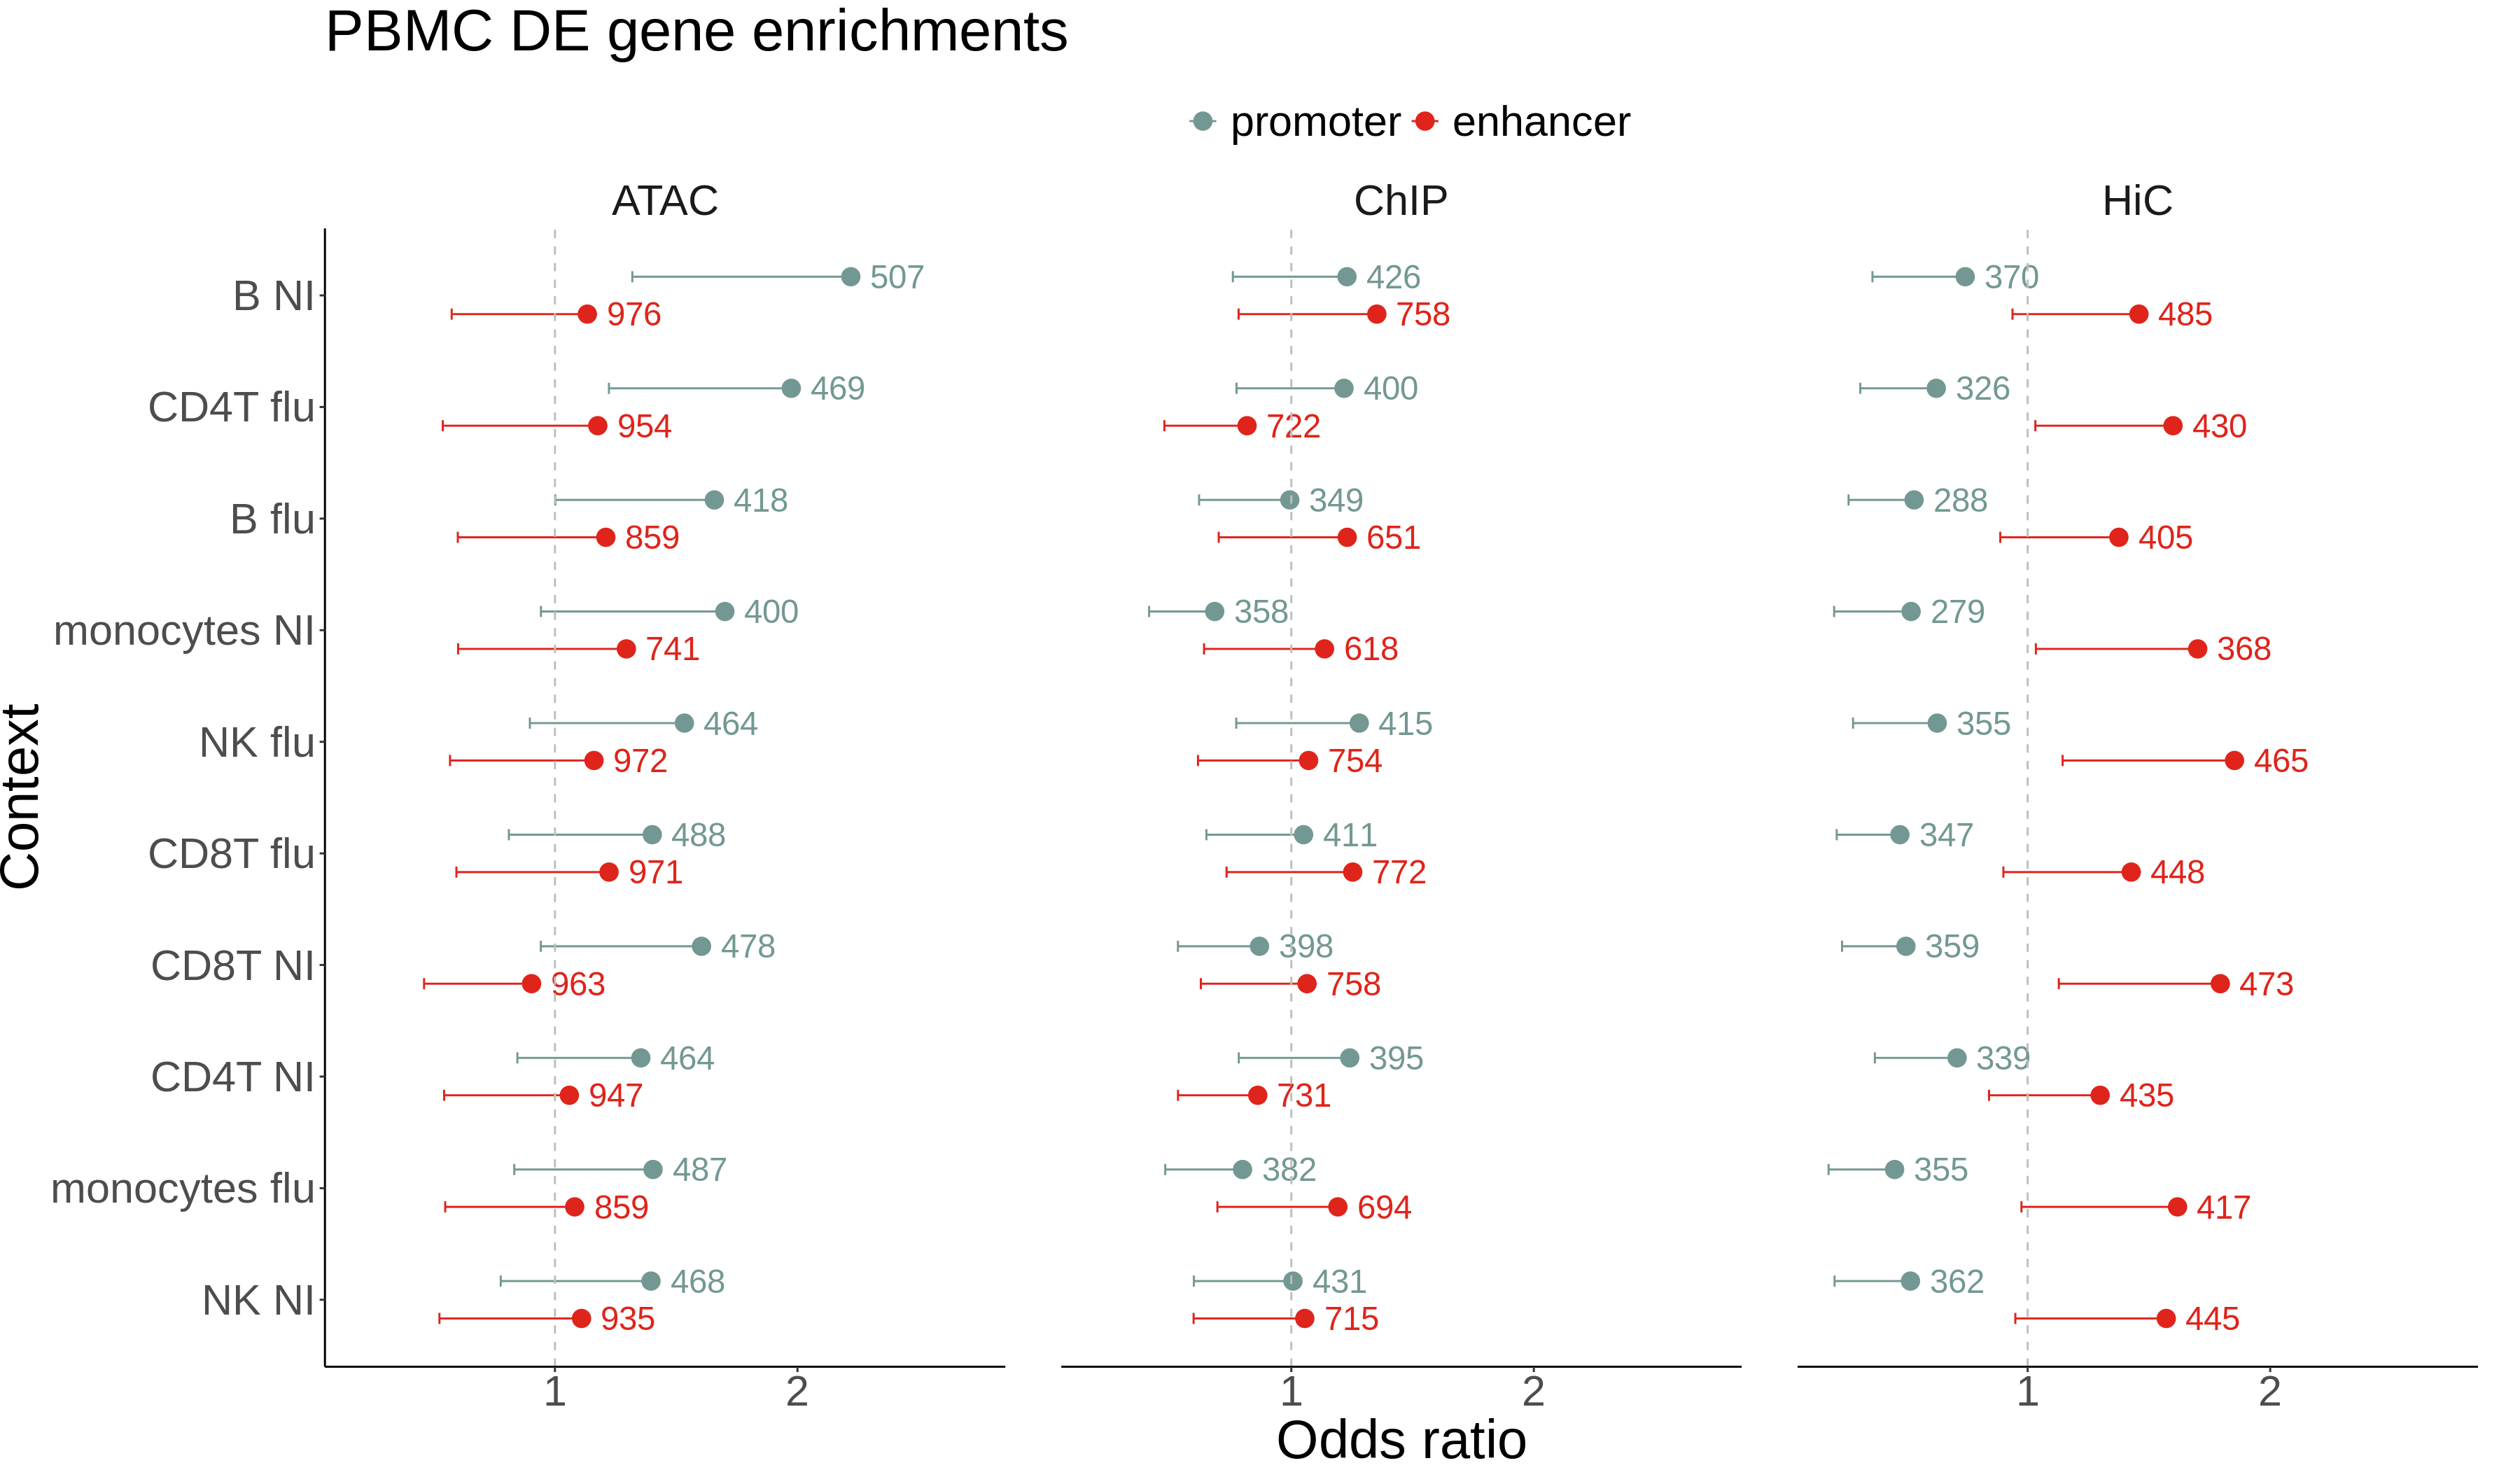

In [52]:
ntests <- 88

plotFisherEnrichments(fe %>% 
                          dplyr::filter(datatype=='pseudobulk',
                                        !is.na(self_promoter),
                                            !doublecount_enh,
                                        score_type!='ABC') %>% 
                              mutate(padj = case_when(score_type %in% c('ATAC','ChIP') ~ pvalue*ntests,
                                                      TRUE ~ 1)),
                      yvar_col='celltype_condition',
                      ylabel='Context',
                      xlabel="Odds ratio",
                      althypoth='greater',
                      groupvar='self_promoter',
                      groupvarord=NULL,
                      groupvarlab=NULL,
                      colorvals=cre_colors,
                      dodgewidth=0.67,
                      sep_groups=FALSE,
                      w=sdim[2],
                      h=sdim[1],
                      facets='score_type',
                      frows=1,
                      fscales='fixed', # free, free_x, free_y
                      fdir='h',
                      legendpos='top', # c(xpos, ypos)
                      debug=FALSE) + 
        ggtitle("PBMC DE gene enrichments") +
        theme(plot.title = element_text(size=30, hjust=0, margin=margin(5,0,15,0)))

ggsave(
    file.path(
        outdir, 
        'FigS2b.png'
    ),
    width=sdim[2], 
    height=sdim[1]
)

## g

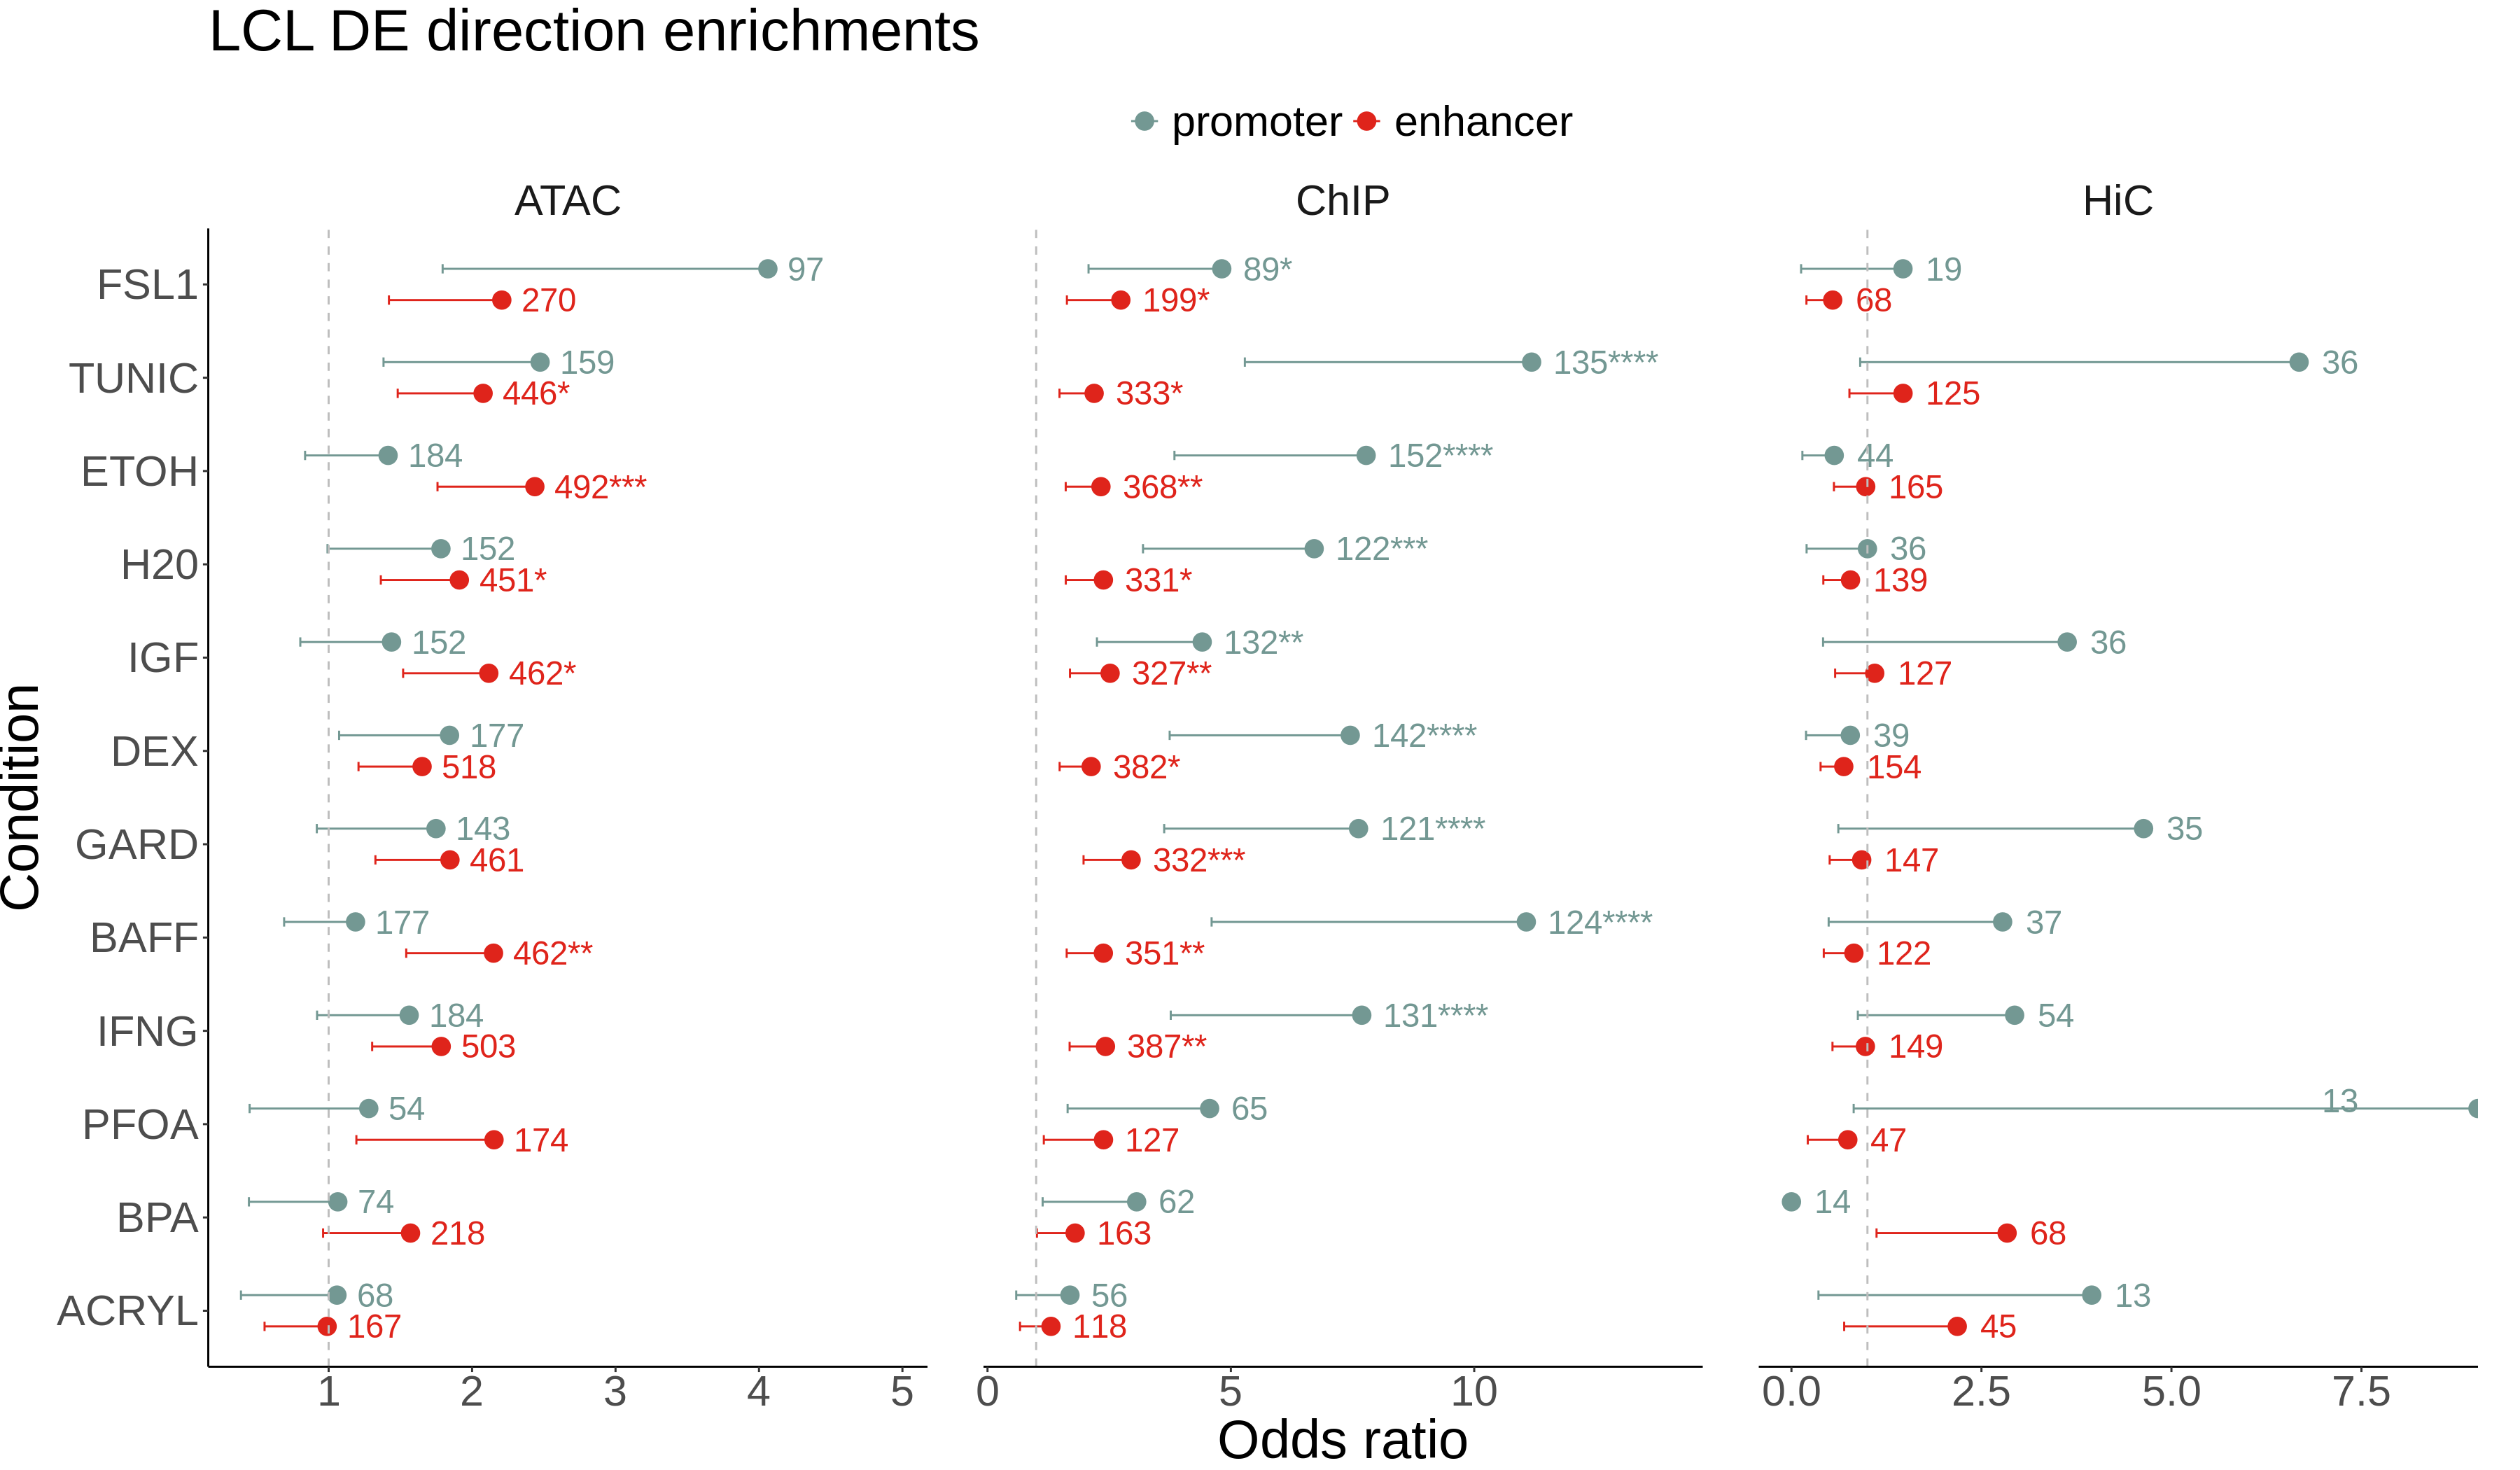

In [53]:
ntests <- 88

plotFisherEnrichments(fer %>% 
                          dplyr::filter(datatype=='bulk',
                                        !is.na(self_promoter),
                                            !doublecount_enh,
                                        score_type!='ABC') %>% 
                              mutate(padj = case_when(score_type %in% c('ATAC','ChIP') ~ pvalue*ntests,
                                                      TRUE ~ 1)),
                      yvar_col='condition',
                      ylabel='Condition',
                      xlabel="Odds ratio",
                      althypoth='greater',
                      groupvar='self_promoter',
                      groupvarord=NULL,
                      groupvarlab=NULL,
                      colorvals=cre_colors,
                      dodgewidth=0.67,
                      sep_groups=FALSE,
                      w=sdim[2],
                      h=sdim[1],
                      facets='score_type',
                      frows=1,
                      fscales='free_x', # free, free_x, free_y
                      fdir='h',
                      legendpos='top', # c(xpos, ypos)
                      debug=FALSE) +
        ggtitle("LCL DE direction enrichments") +
        theme(plot.title = element_text(size=30, hjust=0, margin=margin(5,0,15,0)))

ggsave(
    file.path(
        outdir, 
        'FigS2c.png'
    ),
    width=sdim[2], 
    height=sdim[1]
)

## h

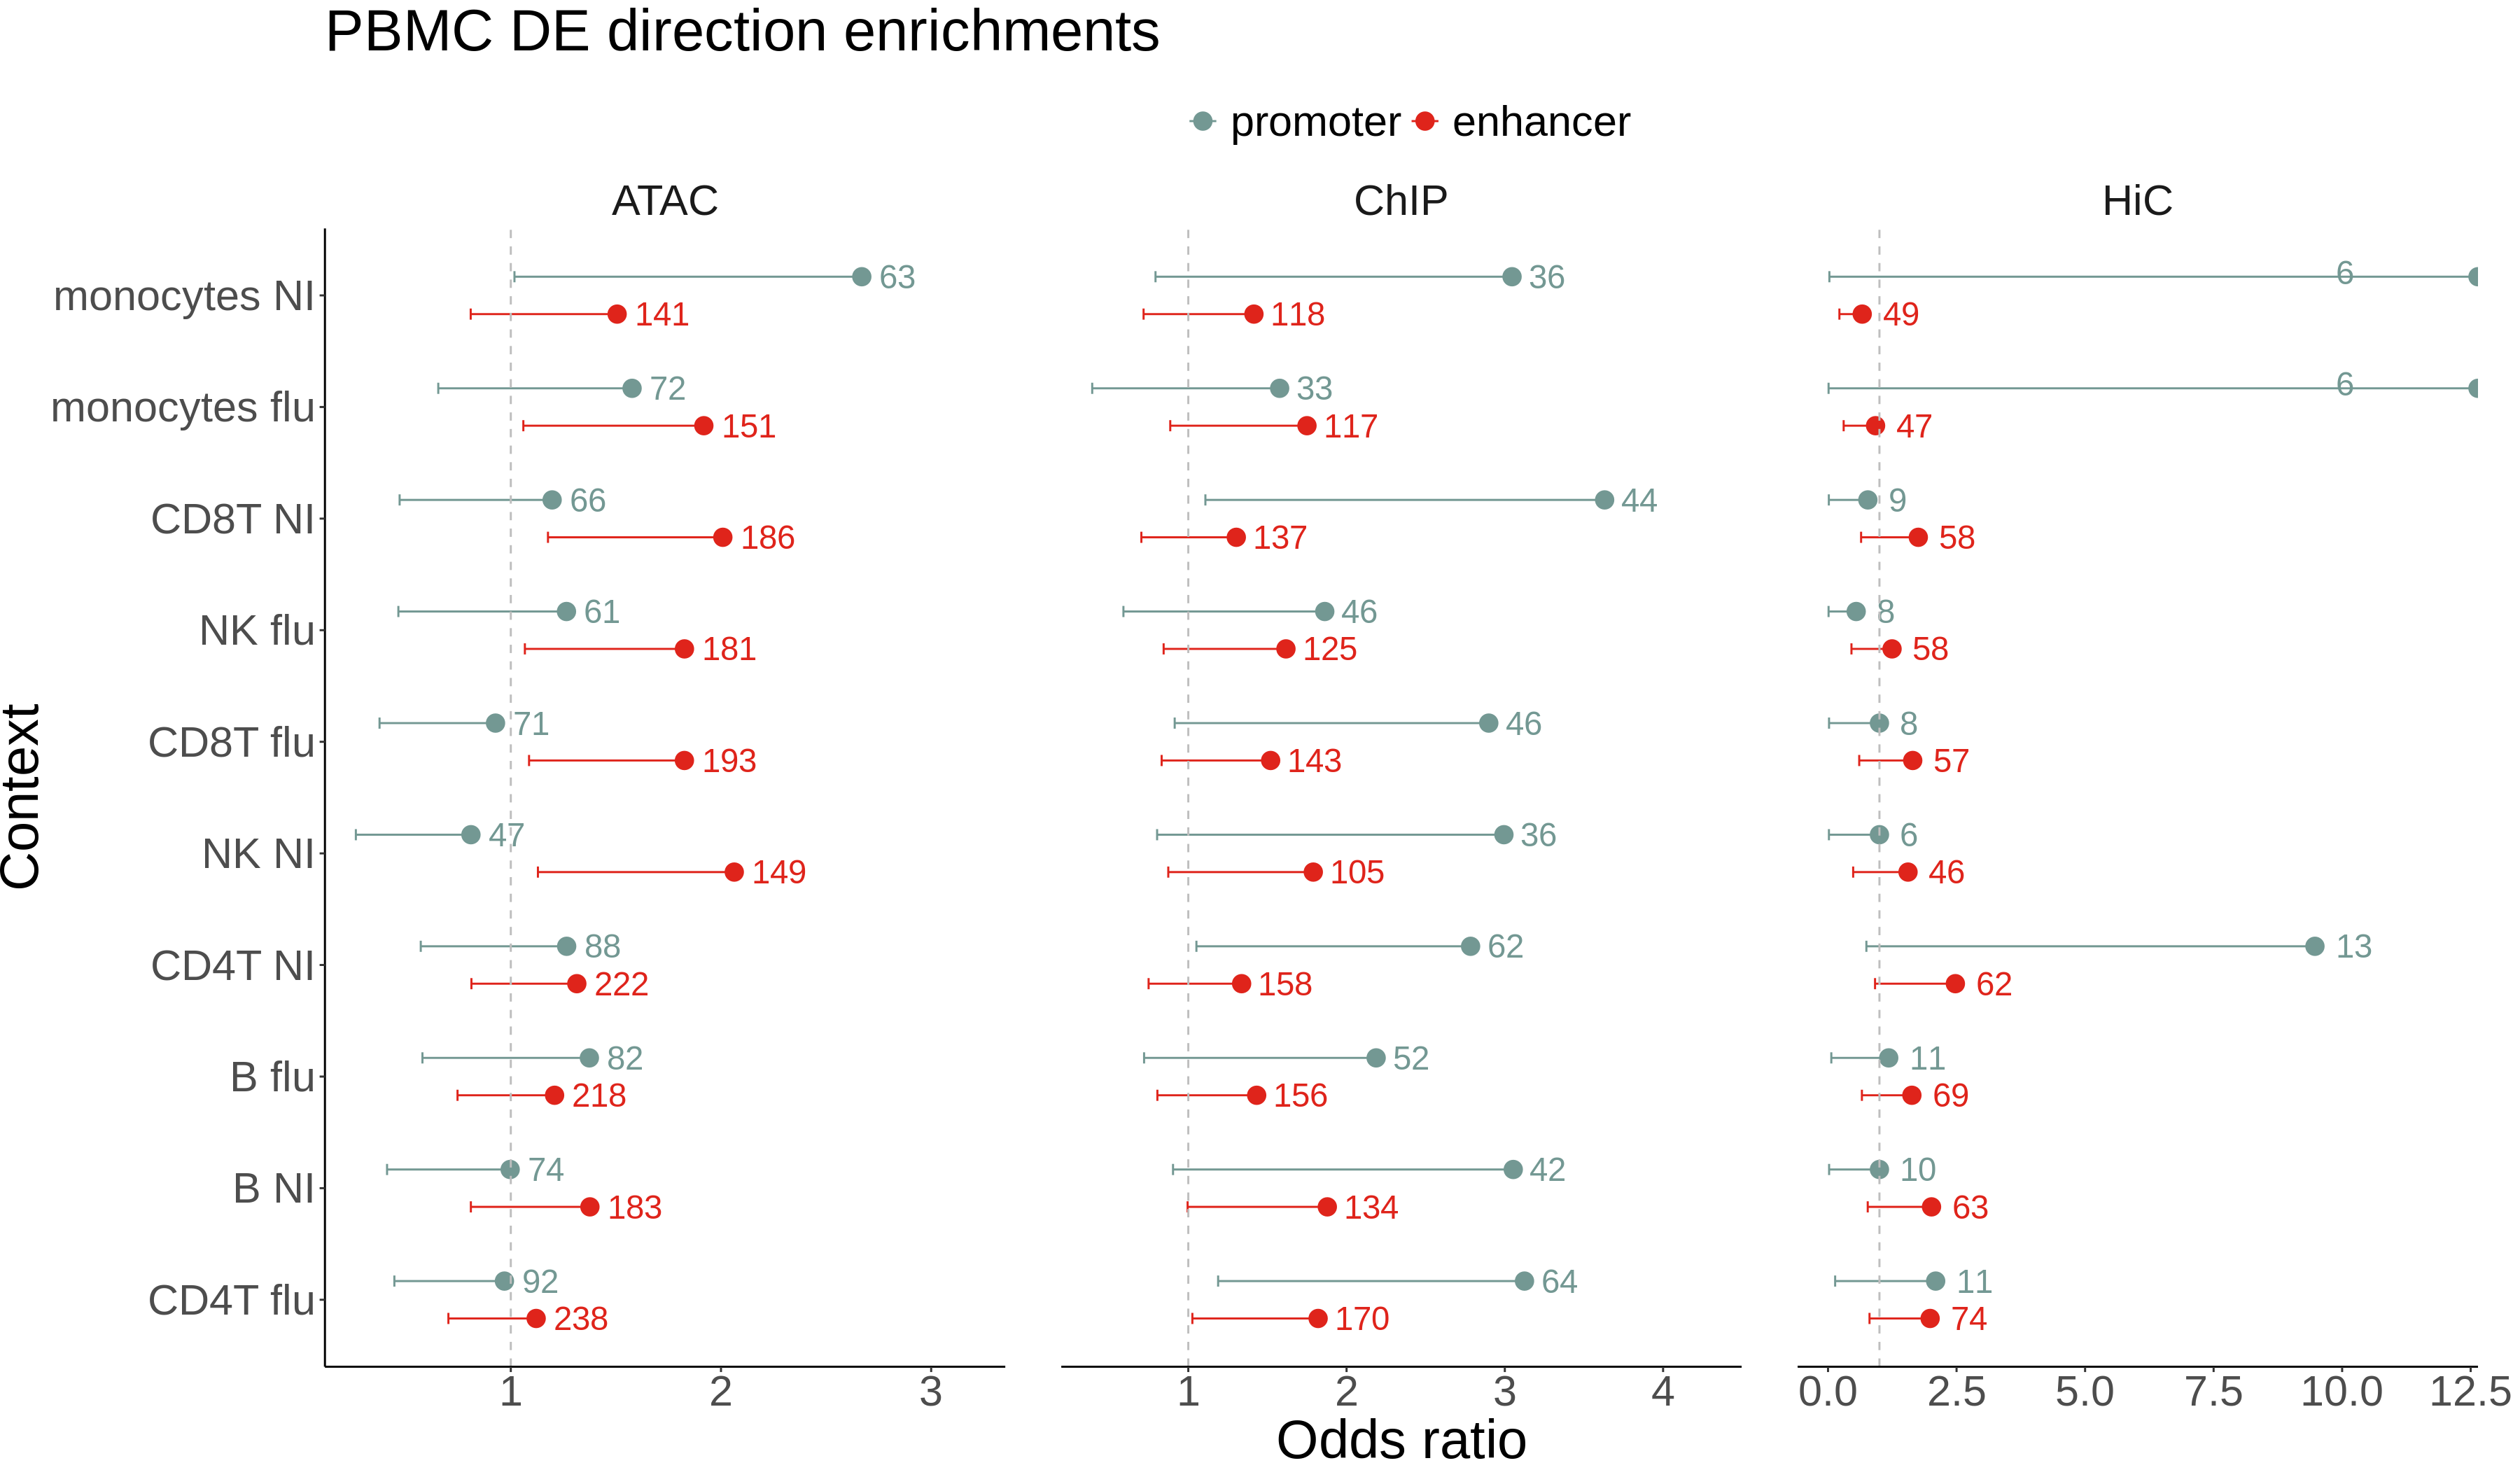

In [54]:
ntests <- 88

plotFisherEnrichments(fer %>% 
                          dplyr::filter(datatype=='pseudobulk',
                                        !is.na(self_promoter),
                                            !doublecount_enh,
                                        score_type!='ABC') %>% 
                              mutate(padj = case_when(score_type %in% c('ATAC','ChIP') ~ pvalue*ntests,
                                                      TRUE ~ 1)),
                      yvar_col='celltype_condition',
                      ylabel='Context',
                      xlabel="Odds ratio",
                      althypoth='greater',
                      groupvar='self_promoter',
                      groupvarord=NULL,
                      groupvarlab=NULL,
                      colorvals=cre_colors,
                      dodgewidth=0.67,
                      sep_groups=FALSE,
                      w=sdim[2],
                      h=sdim[1],
                      facets='score_type',
                      frows=1,
                      fscales='free_x', # free, free_x, free_y
                      fdir='h',
                      legendpos='top', # c(xpos, ypos)
                      debug=FALSE) +
        ggtitle("PBMC DE direction enrichments") +
        theme(plot.title = element_text(size=30, hjust=0, margin=margin(5,0,15,0)))

ggsave(
    file.path(
        outdir, 
        'FigS2d.png'
    ),
    width=sdim[2], 
    height=sdim[1]
)

## i

In [39]:
groupedBoxplot <- function(df,
                           xvar,
                           yvar,
                           groupvar='replicate',
                           xlab=xvar,
                           ylab=yvar,
                           plotpoints=FALSE,
                           points_thresh=200, # show all points for xvar with N observations below this number
                           show_wilcox=FALSE,
                           paired_t_test=FALSE,
                           alt='two.sided',
                           pvalsize=4,
                           ylimadj=0,
                           orderpval=FALSE,
                           logscale=FALSE,
                           colorX=FALSE,
                           colorvals=NULL,
                           showleg=FALSE,
                           legendpos='right',
                           legtextsize=12,
                           horizontal=TRUE,
                           facets=NULL,
                           frows=2,
                           fscales='fixed',
                           fdir='h',
                           w=7,h=7,
                           angleHjVj=c(20,.5,.5),
                           debug=FALSE) {

    options(repr.plot.width = w, repr.plot.height = h, repr.plot.res = 200)

    if (colorX) {
        colorvar <- xvar
    } else {
        colorvar <- groupvar
    }
    outliers <- 0.2
    if (plotpoints) outliers <- 0.0

    if (horizontal) {
      ytextjust <- 0.9
    } else {
      ytextjust <- 1.1
    }

    if (show_wilcox & is.null(groupvar)) {

        testTypes <- df %>%
            group_by(across(any_of(facets))) %>%
            dplyr::rename(xvarvals := {{xvar}}) %>%
            summarize(Nxvar = n_distinct(xvarvals)) %>%
            dplyr::filter(Nxvar == 2) %>%
            ungroup() %>%
            dplyr::select(any_of(facets)) %>%
            distinct()

#         wilcox_df <- df %>%
#             group_by(across(any_of(c(facets,xvar)))) %>%
#             summarize(N = dplyr::n())

        wilcox_df <- merge(df, testTypes) %>%
            group_by(across(any_of(facets))) %>%
            dplyr::rename(wilcox_test_var := {{xvar}},
                          ycol := {{yvar}}) %>%
            mutate(maxy = max(ycol)*ytextjust) %>%
            group_by(maxy, .add=TRUE)

        if (paired_t_test) {
            wilcox_df <- wilcox_df %>%
                rstatix::t_test(ycol ~ wilcox_test_var,
                                paired=TRUE,
                                p.adjust.method='none')
        } else {
            wilcox_df <- wilcox_df %>%
                rstatix::wilcox_test(ycol ~ wilcox_test_var,
                                     alternative=alt,
                                     p.adjust.method='none')
        }
        wilcox_df <- wilcox_df %>%
            mutate(!!xvar := group1,
                   xposn = 1.5,
                   yposn=maxy,
                   wilcox_lab = paste0('P = ', signif(p, digits=2)))

        if (orderpval) {
            wilcox_df <- wilcox_df %>%
                arrange(p) %>%
                mutate(across(all_of(facets), ~ fct_reorder(as_factor(.x), p)))

            df <- df %>%
                mutate(across(all_of(facets), ~ factor(.x, levels=unique(wilcox_df$.x))))

        }

    } else if (show_wilcox) {
        wilcox_df <- df %>%
            group_by(across(any_of(facets))) %>%
            dplyr::rename(wilcox_test_var := {{groupvar}},
                          ycol := {{yvar}}) %>%
            mutate(maxy = max(ycol)*ytextjust) %>%
            group_by(maxy, across(any_of(xvar)), .add=TRUE)

        if (paired_t_test) {
            wilcox_df <- wilcox_df %>%
                rstatix::t_test(ycol ~ wilcox_test_var,
                                paired=TRUE,
                                p.adjust.method='none')
        } else {
            wilcox_df <- wilcox_df %>%
                rstatix::wilcox_test(ycol ~ wilcox_test_var,
                                     alternative=alt,
                                     p.adjust.method='none')
        }

        wilcox_df <- wilcox_df %>%
            mutate(yposn=maxy,
                   wilcox_lab = paste0('P=', signif(p, digits=2)))
    }

    wilcox_df <- wilcox_df %>%
        mutate(padj = p*dplyr::n(),
               wilcox_lab = case_when(padj < 0.00005 ~ paste0(wilcox_lab, '****'),
                                      padj < 0.0005 ~ paste0(wilcox_lab, '***'),
                                      padj < 0.005 ~ paste0(wilcox_lab, '**'),
                                      padj < 0.05 ~ paste0(wilcox_lab, '*'),
                                      TRUE ~ wilcox_lab))

    if (debug) return(wilcox_df)


    if (!is.null(groupvar)) {
        p1 <- df %>%
            ggplot(aes(x=.data[[xvar]],
                       y=.data[[yvar]],
                       fill=.data[[colorvar]],
                       alpha=.data[[groupvar]]))
    } else {
        p1 <- df %>%
            ggplot(aes(x=.data[[xvar]],
                       y=.data[[yvar]],
                       fill=.data[[colorvar]]))
    }



    p1 <- p1 +
        geom_boxplot(outlier.alpha=outliers,
                     show.legend=showleg)

    if (plotpoints) {
        posd <- position_jitter()
        if (!is.null(groupvar)) posd <- position_jitterdodge(jitter.width=0.3,dodge.width=0.75)

        dfo <- df %>%
            group_by(across(all_of(c(facets,xvar)))) %>%
            dplyr::filter(dplyr::n() >= points_thresh) %>%
            ungroup()
        p1 <- p1 +
            geom_boxplot(data=dfo,
                         outlier.alpha=0.2,
                         show.legend=showleg)

        dfp <- df %>%
            group_by(across(all_of(c(facets,xvar)))) %>%
            dplyr::filter(dplyr::n() < points_thresh) %>%
            ungroup()
        p1 <- p1 +
            geom_point(data=dfp,
                       pch=21,
                       position = posd,
                       show.legend=FALSE)
    }


    if (show_wilcox) {
        
        # dummy df for plottin blank space for text labels
        ylim_blank <- df %>%
            group_by(across(all_of(facets))) %>%
            mutate(or_ylim = max(.data[[yvar]])*(1+ylimadj)) 
        
        if (is.null(groupvar)) {
            ylim_blank <- ylim_blank %>% 
                dplyr::select(any_of(c(facets, xvar, yvar,'or_ylim')))
                
            p1 <- p1 +
                geom_text(data=wilcox_df,
                          aes(x=xposn,y=yposn,label=wilcox_lab), size=pvalsize, fontface='italic')
        } else {
            ylim_blank <- ylim_blank %>% 
                dplyr::select(any_of(c(facets, groupvar, xvar, yvar,'or_ylim')))
            
            p1 <- p1 +
                geom_text(data=wilcox_df,
                          inherit.aes=FALSE,
                          aes(x=.data[[xvar]],y=yposn,label=wilcox_lab), size=pvalsize, fontface='italic')
        }
        
        if (ylimadj>0) p1 <- p1 + geom_blank(data=ylim_blank, aes(x=.data[[xvar]], y=or_ylim, color=NULL))

    } 



    if (!is.null(facets)) {

       p1 <- p1 +
            facet_wrap(facets, nrow=frows, dir=fdir, scales=fscales)
    }


    if (!is.null(colorvals)) {

        p1 <- p1 +
            scale_fill_manual(values=colorvals) +
            scale_color_manual(values=colorvals)

    }

    if (logscale) {
        p1 <- p1 + scale_y_log10()
    }
    if (horizontal) p1 <- p1 + coord_flip()

    p1 <- p1 +
        scale_alpha_manual(values=rep(1, df[[colorvar]] %>% n_distinct())) +
        labs(y = ylab,
             x = xlab) +
        theme_classic() +
        theme(axis.text.x = element_text(size=16,angle=angleHjVj[1],hjust=angleHjVj[2],vjust=angleHjVj[3]),
              axis.text.y = element_text(size=16),
              axis.title.x = element_text(size=22),
              axis.title.y = element_text(size=22),
              plot.margin = unit(c(0,1,0,0),"line"),
              legend.position = legendpos,
              legend.title = element_text(size=legtextsize),
              legend.text = element_text(size=legtextsize),
              strip.background = element_blank(),
              strip.placement = "outside",
              strip.text = element_text(size=18))



    return(p1)
}

In [23]:
afe %>% 
    dplyr::filter(score_type %in% c('ATAC','ChIP'),
                                  datatype %in% c('bulk','pseudobulk'),
                                  !doublecount_enh)

odds_ratio,pvalue,conf_lower,conf_upper,condition,celltype,datatype,self_promoter,doublecount_enh,score_type,celltype_condition,test_type
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>
1.234422,1.637200e-01,0.8835090,Inf,ACRYL,LCL,bulk,NA,FALSE,ATAC,LCL ACRYL,diff
0.978749,5.883594e-01,0.6436660,Inf,ACRYL,LCL,bulk,promoter,FALSE,ATAC,LCL ACRYL,diff
2.064576,5.269186e-02,0.9910701,Inf,ACRYL,LCL,bulk,enhancer,FALSE,ATAC,LCL ACRYL,diff
1.585570,5.711884e-04,1.2454742,Inf,BAFF,LCL,bulk,NA,FALSE,ATAC,LCL BAFF,diff
1.505120,1.890149e-02,1.0829524,Inf,BAFF,LCL,bulk,promoter,FALSE,ATAC,LCL BAFF,diff
1.209180,2.360363e-01,0.8143761,Inf,BAFF,LCL,bulk,enhancer,FALSE,ATAC,LCL BAFF,diff
1.728595,2.941632e-03,1.2262973,Inf,BPA,LCL,bulk,NA,FALSE,ATAC,LCL BPA,diff
1.663277,4.091641e-02,1.0248484,Inf,BPA,LCL,bulk,promoter,FALSE,ATAC,LCL BPA,diff
1.268619,2.702016e-01,0.7465000,Inf,BPA,LCL,bulk,enhancer,FALSE,ATAC,LCL BPA,diff


In [68]:
afe %>% 
                    mutate(cre_type = case_when(is.na(self_promoter) ~ 'all CREs',
                                                TRUE ~ paste0(self_promoter, 's')),
                           cre_type = fct_relevel(factor(cre_type), c('all CREs','promoters','enhancers')),
                           test_type = if_else(test_type=='direction',
                                               'differential\nexpression\ndirection\nmatching',
                                               'differential\nexpression'),
                           test_type = fct_relevel(factor(test_type), rev)) %>% 
                    dplyr::filter(score_type %in% c('ATAC','ChIP'),
                                  datatype %in% c('bulk','pseudobulk'),
                                  !doublecount_enh)

odds_ratio,pvalue,conf_lower,conf_upper,condition,celltype,datatype,self_promoter,doublecount_enh,score_type,celltype_condition,test_type,cre_type
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<fct>,<fct>
1.234422,1.637200e-01,0.8835090,Inf,ACRYL,LCL,bulk,NA,FALSE,ATAC,LCL ACRYL,differential expression,all CREs
0.978749,5.883594e-01,0.6436660,Inf,ACRYL,LCL,bulk,promoter,FALSE,ATAC,LCL ACRYL,differential expression,promoters
2.064576,5.269186e-02,0.9910701,Inf,ACRYL,LCL,bulk,enhancer,FALSE,ATAC,LCL ACRYL,differential expression,enhancers
1.585570,5.711884e-04,1.2454742,Inf,BAFF,LCL,bulk,NA,FALSE,ATAC,LCL BAFF,differential expression,all CREs
1.505120,1.890149e-02,1.0829524,Inf,BAFF,LCL,bulk,promoter,FALSE,ATAC,LCL BAFF,differential expression,promoters
1.209180,2.360363e-01,0.8143761,Inf,BAFF,LCL,bulk,enhancer,FALSE,ATAC,LCL BAFF,differential expression,enhancers
1.728595,2.941632e-03,1.2262973,Inf,BPA,LCL,bulk,NA,FALSE,ATAC,LCL BPA,differential expression,all CREs
1.663277,4.091641e-02,1.0248484,Inf,BPA,LCL,bulk,promoter,FALSE,ATAC,LCL BPA,differential expression,promoters
1.268619,2.702016e-01,0.7465000,Inf,BPA,LCL,bulk,enhancer,FALSE,ATAC,LCL BPA,differential expression,enhancers


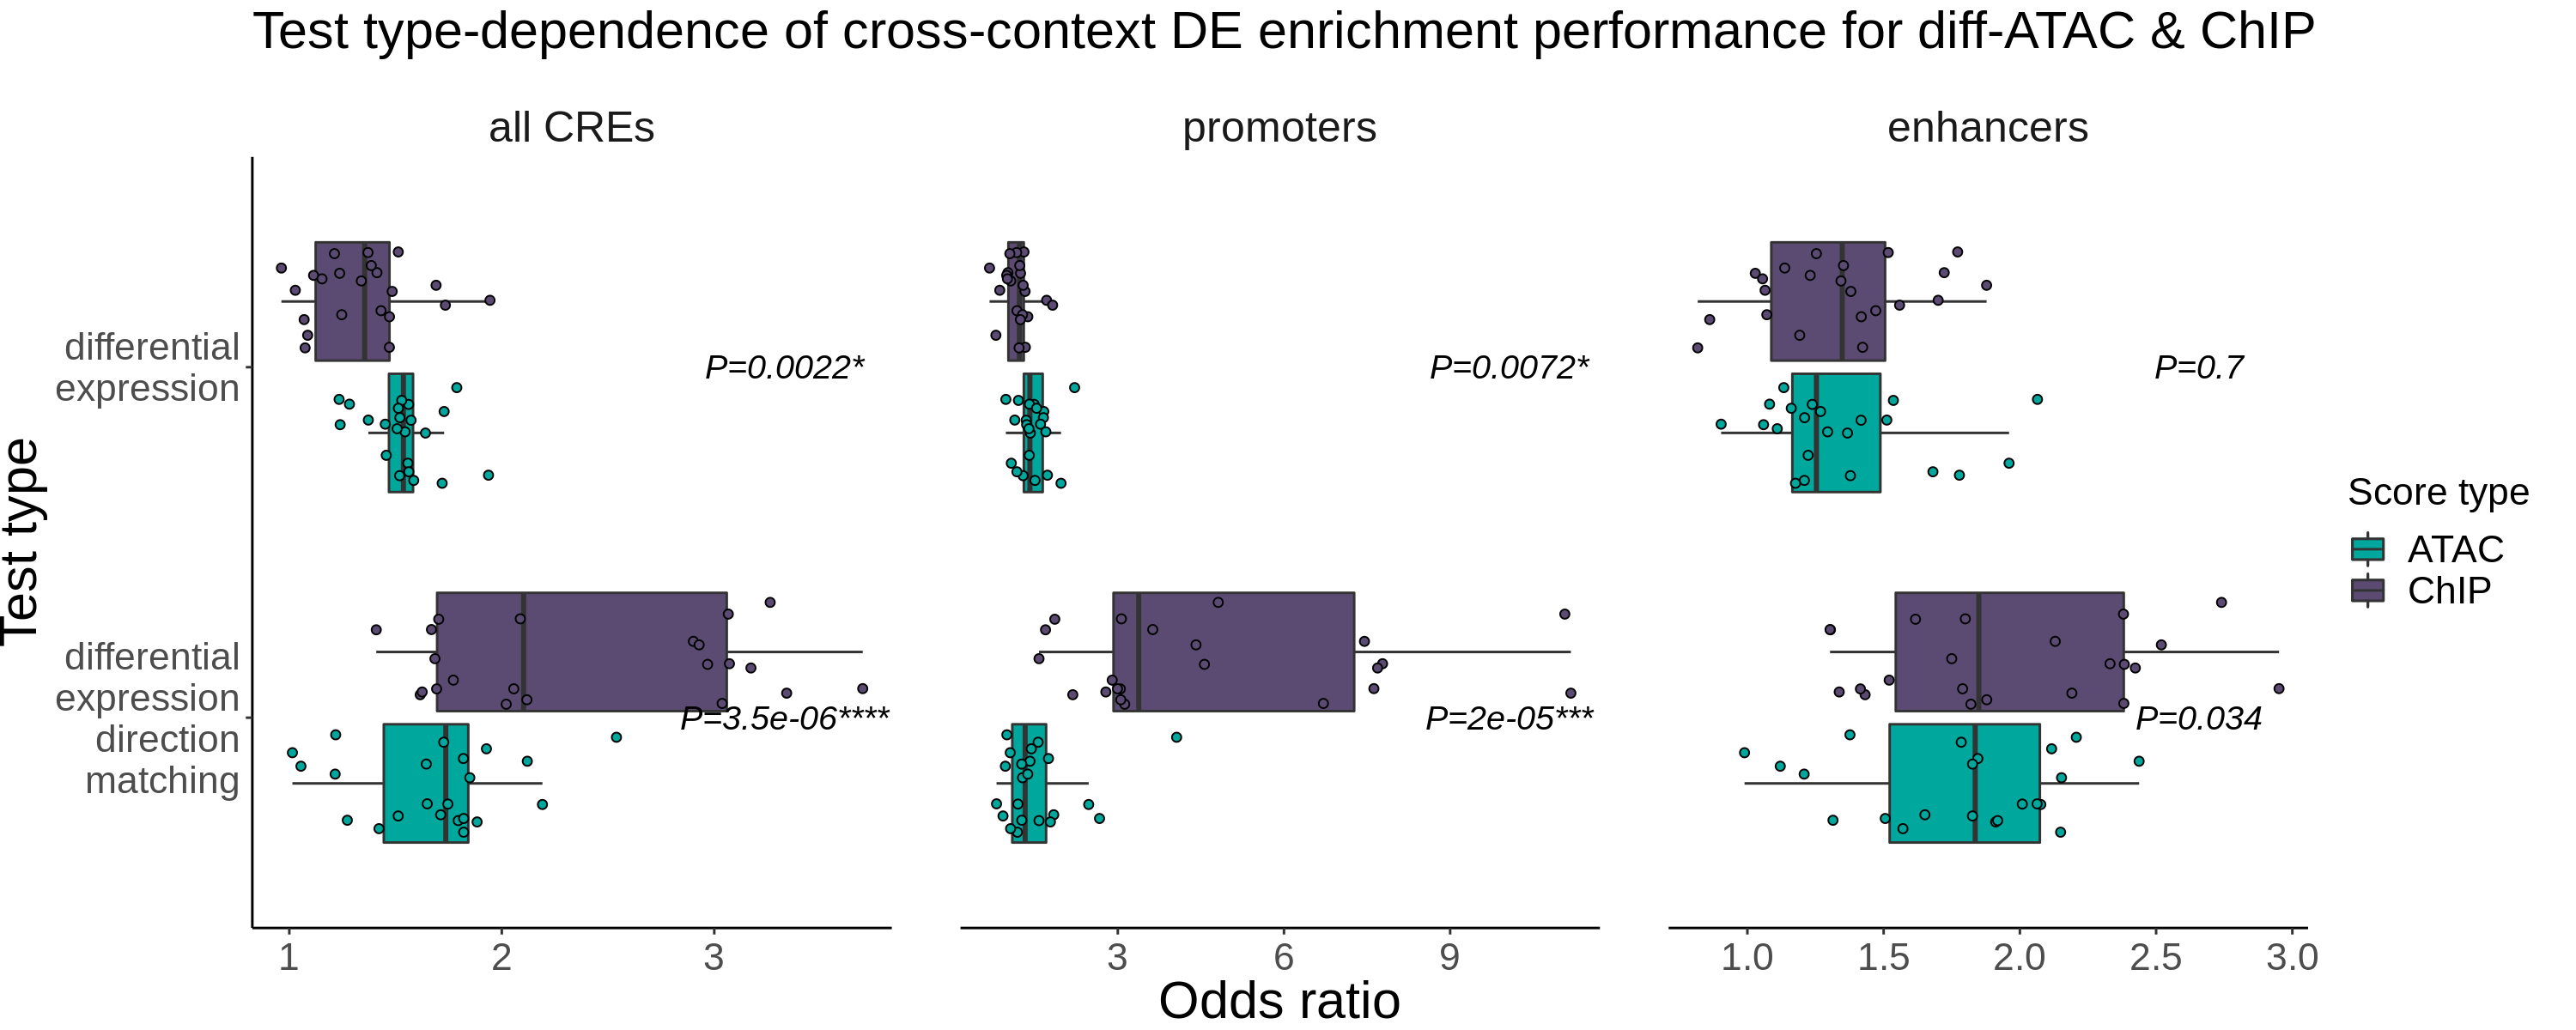

In [70]:
groupedBoxplot(afe %>% 
                    mutate(cre_type = case_when(is.na(self_promoter) ~ 'all CREs',
                                                TRUE ~ paste0(self_promoter, 's')),
                           cre_type = fct_relevel(factor(cre_type), c('all CREs','promoters','enhancers')),
                           test_type = if_else(test_type=='direction',
                                               'differential\nexpression\ndirection\nmatching',
                                               'differential\nexpression'),
                           test_type = fct_relevel(factor(test_type), rev)) %>% 
                    dplyr::filter(score_type %in% c('ATAC','ChIP'),
                                  datatype %in% c('bulk','pseudobulk'),
                                  !doublecount_enh),
                           'test_type',
                           'odds_ratio',
                           groupvar='score_type',
                           xlab='Test type',
                           ylab='Odds ratio',
                           plotpoints=TRUE,
                           points_thresh=200, # show all points for xvar with N observations below this number
                           show_wilcox=TRUE,
                           paired_t_test=TRUE,
                           pvalsize=5,
                           ylimadj=0,
                           alt='two.sided',
                           orderpval=FALSE,
                           logscale=FALSE,
                           colorX=FALSE,
                           colorvals=c("#00A79C","#5B4B73"),
                           showleg=TRUE,
                           legtextsize=16,
                           legendpos='right',
                           horizontal=TRUE,
                           facets=c('cre_type'),
                           frows=1,
                           fscales='free_x',
                           fdir='h',
                           w=15,h=6,
                           angleHjVj=c(0,.5,.5),
                           debug=FALSE) +
        ggtitle("Test type-dependence of cross-context DE enrichment performance for diff-ATAC & ChIP") +
        theme(plot.title = element_text(size=22, hjust=0, margin=margin(5,0,15,0)),
              panel.spacing = unit(2, "line")) + 
    labs(fill='Score type', alpha='Score type')

ggsave(
    file.path(
        outdir, 
        'FigS2e_TD.png'
    ),
    width=15, 
    height=6
)
